<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/main/Predict_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from google.colab import files
uploaded = files.upload()

Saving ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving WMT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to WMT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Savi

## Import packages

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Get data at pattern for training & testing

In [4]:
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
for filename in uploaded.keys():
    print(filename)
    if 'double_top_data_patterns.csv' not in filename:
    # if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
                     header=None)
    price_patterns_df = price_patterns_df.append(df)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
WMT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
WFC_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
W_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VZ_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VXRT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VICI_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VIAC_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
V_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
TSLA_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
T_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,55.230000,54.740002,54.020000,53.560001,52.480000,52.529999,53.160000,53.279999,54.290001,54.369999,55.290001,55.779999,54.520000,55.770000,56.810001,55.919998,53.970001,53.930000,55.299999,52.680000,52.000000,52.849998,53.410000,53.459999,53.389999,54.599998,53.580002,54.259998,53.980000,52.830002,54.060001
1,29.549999,29.150000,28.600000,29.000000,28.700001,30.700001,30.600000,29.750000,30.350000,30.650000,30.950001,30.450001,30.299999,30.799999,30.200001,30.250000,30.400000,30.000000,31.000000,31.000000,31.500000,31.900000,31.850000,31.600000,30.950001,30.650000,30.049999,30.100000,30.150000,29.450001,29.500000
2,72.589996,73.260002,73.440002,72.559998,73.279999,72.660004,73.300003,74.089996,72.330002,71.000000,71.860001,71.400002,71.410004,70.269997,71.489998,71.910004,71.129997,71.180000,72.860001,74.190002,74.720001,76.190002,76.070000,77.300003,78.820000,78.489998,78.110001,78.540001,78.800003,77.970001,79.980003
3,28.320000,28.490000,28.440001,28.240000,28.000000,27.969999,27.690001,28.240000,28.049999,28.370001,28.110001,27.990000,28.910000,28.200001,27.920000,28.209999,28.780001,28.290001,28.559999,28.920000,29.260000,28.490000,28.760000,29.110001,28.830000,28.799999,28.590000,28.030001,28.049999,27.670000,27.790001
4,23.500000,23.400000,23.459999,25.430000,25.010000,25.740000,26.799999,27.600000,26.410000,27.080000,27.650000,27.750000,27.400000,28.400000,27.950001,27.389999,27.010000,27.799999,27.549999,28.709999,28.190001,28.299999,28.270000,27.400000,28.450001,27.580000,27.600000,27.100000,27.049999,26.860001,26.799999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,23.990000,24.770000,25.570000,25.639999,25.799999,25.830000,25.620001,26.559999,26.309999,26.530001,26.700001,26.570000,26.760000,26.790001,26.730000,26.600000,26.299999,26.809999,26.080000,26.500000,26.200001,25.790001,25.840000,26.040001,26.270000,26.240000,26.510000,26.469999,25.870001,25.620001,25.590000
9975,150.509995,153.839996,154.949997,156.839996,159.789993,161.059998,162.660004,161.440002,160.460007,160.320007,162.949997,164.740005,162.550003,161.009995,156.149994,157.500000,158.850006,158.029999,158.550003,158.500000,161.509995,161.690002,162.490005,161.000000,162.860001,160.889999,160.619995,162.880005,162.029999,150.229996,147.350006
9976,48.689999,37.029999,38.500000,38.930000,38.439999,38.369999,38.389999,38.250000,38.250000,37.830002,37.840000,37.930000,37.959999,38.340000,37.320000,36.430000,37.340000,36.400002,36.689999,37.040001,38.160000,38.400002,37.520000,37.580002,37.169998,37.540001,37.459999,38.080002,37.270000,36.750000,36.770000
9977,21.639999,21.430000,21.000000,21.020000,21.000000,21.410000,21.280001,21.510000,21.510000,21.750000,21.510000,21.940001,21.709999,21.809999,21.930000,21.950001,21.900000,22.000000,22.110001,21.610001,21.879999,21.900000,22.070000,22.070000,22.030001,21.820000,21.610001,22.139999,21.620001,21.459999,21.450001


In [5]:
#@title Check if data is nearly formed a line
#@markdown ### Delta price distance from data point to trend line
trend_delta = 0.05 #@param {type:"number"}

def is_trend(x_data, y_data):
    assert len(x_data) == len(y_data)
    if len(x_data) < 2:
        return False
    # print(x_data)
    # print(y_data)
    # Find the line from the first to the last point
    # y = a * x + b
    x1, y1 = x_data[0], y_data[0]
    x2, y2 = x_data[-1], y_data[-1]
    a = (y1 - y2) / (x1 - x2)  # slope
    b = y1 - a * x1  # intercept
    b_is_trend = True
    for i in range(len(x_data)):
        y_val = a * x_data[i] + b
        err = abs(y_val - y_data[i])
        if (err > trend_delta * y_val):
            b_is_trend = False
            break
    return b_is_trend
    # p, res, _, _, _ = np.polyfit(x_data, y_data, 1, full=True)
    # err = res[0] if res.size > 0 else 0
    # if err <= len(x_data) * trend_delta:
    #     return True
    # return False

In [6]:
#@markdown ### Delta price distance between 2 tops/bottoms
y_delta =  0.5#@param {type:"number"}
min_height = 0.5 #@param {type:"number"}

In [7]:
def find_double_top(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_tops = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            # if l == 301 and r == 307:
            #     print(y_data[l], y_data[r], max(y_data[key_points[i + 1: j]]))
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and min(y_data[l], y_data[r]) >= max(y_data[key_points[i + 1: j]]):
                k_bottom = np.argmin(y_data[l + 1: r]) + l + 1
                if min(y_data[l], y_data[r]) < y_data[k_bottom] + min_height:
                    continue
                (ilows,) = np.where(y_data[:l] <= y_data[k_bottom])
                istart = None
                if ilows.size > 0:
                    istart = ilows[-1]
                (ilows,) = np.where(y_data[r:] <= y_data[k_bottom])
                iend = None
                if ilows.size > 0:
                    iend = ilows[0] + r
                # print(istart, l, k_bottom, r, iend)
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_tops.append((istart, l, k_bottom, r, iend))
    return suspected_double_tops

In [8]:
def find_double_bottom(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_bottoms = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and max(y_data[l], y_data[r]) <= min(y_data[key_points[i + 1: j]]):
                k_top = np.argmax(y_data[l + 1: r]) + l + 1
                if max(y_data[l], y_data[r]) + min_height > y_data[k_top]:
                    continue
                (ihights,) = np.where(y_data[:l] >= y_data[k_top])
                istart = None
                if ihights.size > 0:
                    istart = ihights[-1]
                (ihights,) = np.where(y_data[r:] >= y_data[k_top])
                iend = None
                if ihights.size > 0:
                    iend = ihights[0] + r
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_bottoms.append((istart, l, k_top, r, iend))
    return suspected_double_bottoms

In [9]:
for i, row in price_patterns_df.iterrows():
    double_tops = find_double_top(range(len(row)), row.to_numpy())
    double_bots = find_double_bottom(range(len(row)), row.to_numpy())
    print(i, double_tops, double_bots)

Streaming output truncated to the last 5000 lines.
4979 [(11, 12, 13, 14, 16), (23, 24, 25, 27, 29)] [(15, 16, 17, 18, 19)]
4980 [(14, 17, 18, 19, 29)] [(13, 14, 17, 18, 19)]
4981 [(8, 20, 23, 27, 29)] [(5, 8, 20, 23, 27)]
4982 [(20, 22, 26, 28, 29)] []
4983 [(3, 5, 8, 12, 23), (13, 15, 17, 19, 20)] [(5, 11, 12, 13, 14)]
4984 [] []
4985 [(21, 22, 24, 25, 29)] [(2, 4, 5, 6, 8)]
4986 [(24, 25, 26, 27, 29)] []
4987 [(5, 8, 9, 10, 29), (11, 14, 18, 19, 25)] []
4988 [(17, 21, 23, 25, 29), (17, 21, 23, 28, 29)] []
4989 [(11, 13, 18, 23, 29), (11, 16, 18, 23, 29)] []
4990 [] []
4991 [(16, 20, 22, 24, 29)] []
4992 [(14, 15, 16, 18, 29), (14, 15, 16, 19, 29), (19, 20, 23, 24, 27)] []
4993 [(4, 17, 18, 25, 29)] []
4994 [(6, 14, 17, 22, 25)] []
4995 [] [(7, 10, 15, 19, 23)]
4996 [(14, 17, 18, 19, 29)] []
4997 [(15, 18, 20, 22, 29)] []
4998 [(3, 13, 14, 17, 24)] [(13, 16, 17, 19, 21)]
4999 [(5, 6, 8, 9, 10), (23, 24, 26, 28, 29)] []
5000 [(17, 18, 19, 22, 23), (17, 18, 19, 24, 27), (17, 18, 19, 26

In [10]:
#@title Separate into input and output columns: Get data: X and y

X_df = price_patterns_df[price_patterns_df.columns[:-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

              0           1           2   ...          27          28          29
0      55.230000   54.740002   54.020000  ...   54.259998   53.980000   52.830002
1      29.549999   29.150000   28.600000  ...   30.100000   30.150000   29.450001
2      72.589996   73.260002   73.440002  ...   78.540001   78.800003   77.970001
3      28.320000   28.490000   28.440001  ...   28.030001   28.049999   27.670000
4      23.500000   23.400000   23.459999  ...   27.100000   27.049999   26.860001
...          ...         ...         ...  ...         ...         ...         ...
9974   23.990000   24.770000   25.570000  ...   26.469999   25.870001   25.620001
9975  150.509995  153.839996  154.949997  ...  162.880005  162.029999  150.229996
9976   48.689999   37.029999   38.500000  ...   38.080002   37.270000   36.750000
9977   21.639999   21.430000   21.000000  ...   22.139999   21.620001   21.459999
9978   18.879999   18.990000   19.070000  ...   20.889999   21.045000   20.725000

[9979 rows x 30

In [11]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax"]

X_train, y_train = X_data[: n_train], y_data[: n_train]
X_test, y_test = X_data[n_train:], y_data[n_train:]
if scale_method == 'MinMax':
    sc_train = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    sc_test = MinMaxScaler(feature_range = (0, 1))
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)

# print(X_train)
# print(y_train)

(7983, 30) (7983, 1)
(7983, 30) (7983, 1)
(1996, 30) (1996, 1)
(1996, 30) (1996, 1)


## LSTM model

### Build model

In [12]:
#@title Build & fit model
lstm_units = 50 #@param {type:"integer"}
dropout_prob = 0.5 #@param {type:"number"}
epochs = 6000 #@param {type:"integer"}
batch_size = 32768 #@param {type:"integer"}



### Train model

Epoch 1/6000
1/1 [==============================] - 25s 25s/step - loss: 0.2466 - val_loss: 0.2043

Epoch 00001: val_loss improved from inf to 0.20430, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.2108 - val_loss: 0.1726

Epoch 00002: val_loss improved from 0.20430 to 0.17258, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.1808 - val_loss: 0.1455

Epoch 00003: val_loss improved from 0.17258 to 0.14553, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 4/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1575 - val_loss: 0.1289

Epoch 00004: val_loss improved from 0.14553 to 0.12888, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 5/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.1432 - val_loss: 0.1319

Epoch 00005: val_loss did not improve from 0.12888
Epoch 6/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.1521 - val_loss: 0.1361

Epoch 00006: val_loss did not improve from 0.12888
Epoch 7/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.1559 - val_loss: 0.1308

Epoch 00007: val_loss did not improve from 0.12888
Epoch 8/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.1525 - val_loss: 0.1247

Epoch 00008: val_loss improved from 0.12888 to 0.12465, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 9/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1427 - val_loss: 0.1228

Epoch 00009: val_loss improved from 0.12465 to 0.12283, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 10/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.1371 - val_loss: 0.1247

Epoch 00010: val_loss did not improve from 0.12283
Epoch 11/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.1388 - val_loss: 0.1276

Epoch 00011: val_loss did not improve from 0.12283
Epoch 12/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.1392 - val_loss: 0.1296

Epoch 00012: val_loss did not improve from 0.12283
Epoch 13/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.1404 - val_loss: 0.1297

Epoch 00013: val_loss did not improve from 0.12283
Epoch 14/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.1406 - val_loss: 0.1280

Epoch 00014: val_loss did not improve from 0.12283
Epoch 15/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.1397 - val_loss: 0.1250

Epoch 00015: val_loss did not improve from 0.12283
Epoch 16/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.1351 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 17/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1338 - val_loss: 0.1186

Epoch 00017: val_loss improved from 0.12154 to 0.11856, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 18/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.1314 - val_loss: 0.1167

Epoch 00018: val_loss improved from 0.11856 to 0.11670, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 19/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.1304 - val_loss: 0.1160

Epoch 00019: val_loss improved from 0.11670 to 0.11605, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 20/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.1323 - val_loss: 0.1159

Epoch 00020: val_loss improved from 0.11605 to 0.11587, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 21/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.1300 - val_loss: 0.1153

Epoch 00021: val_loss improved from 0.11587 to 0.11526, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 22/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1297 - val_loss: 0.1139

Epoch 00022: val_loss improved from 0.11526 to 0.11387, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 23/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.1283 - val_loss: 0.1122

Epoch 00023: val_loss improved from 0.11387 to 0.11224, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 24/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.1254 - val_loss: 0.1111

Epoch 00024: val_loss improved from 0.11224 to 0.11114, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 25/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1241 - val_loss: 0.1109

Epoch 00025: val_loss improved from 0.11114 to 0.11087, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 26/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1234 - val_loss: 0.1111

Epoch 00026: val_loss did not improve from 0.11087
Epoch 27/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.1224 - val_loss: 0.1110

Epoch 00027: val_loss did not improve from 0.11087
Epoch 28/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.1215 - val_loss: 0.1096

Epoch 00028: val_loss improved from 0.11087 to 0.10962, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 29/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.1215 - val_loss: 0.1071

Epoch 00029: val_loss improved from 0.10962 to 0.10707, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 30/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.1190 - val_loss: 0.1040

Epoch 00030: val_loss improved from 0.10707 to 0.10404, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 31/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1163 - val_loss: 0.1015

Epoch 00031: val_loss improved from 0.10404 to 0.10154, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 32/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1151 - val_loss: 0.0998

Epoch 00032: val_loss improved from 0.10154 to 0.09984, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 33/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1141 - val_loss: 0.0981

Epoch 00033: val_loss improved from 0.09984 to 0.09812, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 34/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1127 - val_loss: 0.0961

Epoch 00034: val_loss improved from 0.09812 to 0.09608, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 35/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.1105 - val_loss: 0.0951

Epoch 00035: val_loss improved from 0.09608 to 0.09514, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 36/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1082 - val_loss: 0.0956

Epoch 00036: val_loss did not improve from 0.09514
Epoch 37/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.1087 - val_loss: 0.0946

Epoch 00037: val_loss improved from 0.09514 to 0.09462, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 38/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.1081 - val_loss: 0.0924

Epoch 00038: val_loss improved from 0.09462 to 0.09237, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 39/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.1061 - val_loss: 0.0919

Epoch 00039: val_loss improved from 0.09237 to 0.09188, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 40/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.1073 - val_loss: 0.0918

Epoch 00040: val_loss improved from 0.09188 to 0.09180, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 41/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.1072 - val_loss: 0.0922

Epoch 00041: val_loss did not improve from 0.09180
Epoch 42/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.1065 - val_loss: 0.0937

Epoch 00042: val_loss did not improve from 0.09180
Epoch 43/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.1062 - val_loss: 0.0930

Epoch 00043: val_loss did not improve from 0.09180
Epoch 44/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.1051 - val_loss: 0.0914

Epoch 00044: val_loss improved from 0.09180 to 0.09137, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 45/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1055 - val_loss: 0.0909

Epoch 00045: val_loss improved from 0.09137 to 0.09089, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 46/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.1052 - val_loss: 0.0908

Epoch 00046: val_loss improved from 0.09089 to 0.09081, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 47/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1044 - val_loss: 0.0911

Epoch 00047: val_loss did not improve from 0.09081
Epoch 48/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.1044 - val_loss: 0.0919

Epoch 00048: val_loss did not improve from 0.09081
Epoch 49/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.1041 - val_loss: 0.0921

Epoch 00049: val_loss did not improve from 0.09081
Epoch 50/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.1036 - val_loss: 0.0915

Epoch 00050: val_loss did not improve from 0.09081
Epoch 51/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.1025 - val_loss: 0.0908

Epoch 00051: val_loss improved from 0.09081 to 0.09076, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 52/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.1026 - val_loss: 0.0904

Epoch 00052: val_loss improved from 0.09076 to 0.09043, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 53/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.1035 - val_loss: 0.0903

Epoch 00053: val_loss improved from 0.09043 to 0.09027, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 54/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.1034 - val_loss: 0.0904

Epoch 00054: val_loss did not improve from 0.09027
Epoch 55/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.1021 - val_loss: 0.0907

Epoch 00055: val_loss did not improve from 0.09027
Epoch 56/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.1033 - val_loss: 0.0906

Epoch 00056: val_loss did not improve from 0.09027
Epoch 57/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.1021 - val_loss: 0.0898

Epoch 00057: val_loss improved from 0.09027 to 0.08983, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 58/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.1021 - val_loss: 0.0892

Epoch 00058: val_loss improved from 0.08983 to 0.08921, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 59/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.1021 - val_loss: 0.0890

Epoch 00059: val_loss improved from 0.08921 to 0.08899, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 60/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.1017 - val_loss: 0.0890

Epoch 00060: val_loss did not improve from 0.08899
Epoch 61/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.1011 - val_loss: 0.0895

Epoch 00061: val_loss did not improve from 0.08899
Epoch 62/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.1015 - val_loss: 0.0897

Epoch 00062: val_loss did not improve from 0.08899
Epoch 63/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.1014 - val_loss: 0.0890

Epoch 00063: val_loss did not improve from 0.08899
Epoch 64/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.1015 - val_loss: 0.0884

Epoch 00064: val_loss improved from 0.08899 to 0.08837, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 65/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0999 - val_loss: 0.0881

Epoch 00065: val_loss improved from 0.08837 to 0.08812, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 66/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0997 - val_loss: 0.0882

Epoch 00066: val_loss did not improve from 0.08812
Epoch 67/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0992 - val_loss: 0.0884

Epoch 00067: val_loss did not improve from 0.08812
Epoch 68/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.1001 - val_loss: 0.0885

Epoch 00068: val_loss did not improve from 0.08812
Epoch 69/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0998 - val_loss: 0.0879

Epoch 00069: val_loss improved from 0.08812 to 0.08790, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 70/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0991 - val_loss: 0.0875

Epoch 00070: val_loss improved from 0.08790 to 0.08747, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 71/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0993 - val_loss: 0.0874

Epoch 00071: val_loss improved from 0.08747 to 0.08738, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 72/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0993 - val_loss: 0.0874

Epoch 00072: val_loss did not improve from 0.08738
Epoch 73/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0983 - val_loss: 0.0873

Epoch 00073: val_loss improved from 0.08738 to 0.08729, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 74/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0989 - val_loss: 0.0870

Epoch 00074: val_loss improved from 0.08729 to 0.08700, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 75/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0984 - val_loss: 0.0867

Epoch 00075: val_loss improved from 0.08700 to 0.08674, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 76/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0990 - val_loss: 0.0865

Epoch 00076: val_loss improved from 0.08674 to 0.08648, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 77/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0984 - val_loss: 0.0864

Epoch 00077: val_loss improved from 0.08648 to 0.08637, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 78/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0980 - val_loss: 0.0863

Epoch 00078: val_loss improved from 0.08637 to 0.08628, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 79/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0974 - val_loss: 0.0861

Epoch 00079: val_loss improved from 0.08628 to 0.08610, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 80/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0983 - val_loss: 0.0858

Epoch 00080: val_loss improved from 0.08610 to 0.08579, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 81/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0980 - val_loss: 0.0855

Epoch 00081: val_loss improved from 0.08579 to 0.08550, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 82/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0981 - val_loss: 0.0854

Epoch 00082: val_loss improved from 0.08550 to 0.08541, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 83/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0978 - val_loss: 0.0853

Epoch 00083: val_loss improved from 0.08541 to 0.08532, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 84/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0966 - val_loss: 0.0849

Epoch 00084: val_loss improved from 0.08532 to 0.08490, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 85/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0967 - val_loss: 0.0846

Epoch 00085: val_loss improved from 0.08490 to 0.08463, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 86/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0964 - val_loss: 0.0847

Epoch 00086: val_loss did not improve from 0.08463
Epoch 87/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0965 - val_loss: 0.0845

Epoch 00087: val_loss improved from 0.08463 to 0.08452, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 88/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0964 - val_loss: 0.0840

Epoch 00088: val_loss improved from 0.08452 to 0.08405, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 89/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0958 - val_loss: 0.0838

Epoch 00089: val_loss improved from 0.08405 to 0.08378, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 90/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0956 - val_loss: 0.0840

Epoch 00090: val_loss did not improve from 0.08378
Epoch 91/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0949 - val_loss: 0.0834

Epoch 00091: val_loss improved from 0.08378 to 0.08344, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 92/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0949 - val_loss: 0.0830

Epoch 00092: val_loss improved from 0.08344 to 0.08301, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 93/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0944 - val_loss: 0.0830

Epoch 00093: val_loss did not improve from 0.08301
Epoch 94/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0944 - val_loss: 0.0830

Epoch 00094: val_loss did not improve from 0.08301
Epoch 95/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0951 - val_loss: 0.0824

Epoch 00095: val_loss improved from 0.08301 to 0.08238, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 96/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0946 - val_loss: 0.0823

Epoch 00096: val_loss improved from 0.08238 to 0.08228, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 97/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0940 - val_loss: 0.0825

Epoch 00097: val_loss did not improve from 0.08228
Epoch 98/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0931 - val_loss: 0.0816

Epoch 00098: val_loss improved from 0.08228 to 0.08159, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 99/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0941 - val_loss: 0.0816

Epoch 00099: val_loss improved from 0.08159 to 0.08158, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 100/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0930 - val_loss: 0.0814

Epoch 00100: val_loss improved from 0.08158 to 0.08135, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 101/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0928 - val_loss: 0.0812

Epoch 00101: val_loss improved from 0.08135 to 0.08118, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 102/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0930 - val_loss: 0.0808

Epoch 00102: val_loss improved from 0.08118 to 0.08082, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 103/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0923 - val_loss: 0.0805

Epoch 00103: val_loss improved from 0.08082 to 0.08047, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 104/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0922 - val_loss: 0.0807

Epoch 00104: val_loss did not improve from 0.08047
Epoch 105/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0919 - val_loss: 0.0798

Epoch 00105: val_loss improved from 0.08047 to 0.07981, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 106/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0926 - val_loss: 0.0803

Epoch 00106: val_loss did not improve from 0.07981
Epoch 107/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0914 - val_loss: 0.0794

Epoch 00107: val_loss improved from 0.07981 to 0.07943, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 108/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0921 - val_loss: 0.0797

Epoch 00108: val_loss did not improve from 0.07943
Epoch 109/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0914 - val_loss: 0.0787

Epoch 00109: val_loss improved from 0.07943 to 0.07870, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 110/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0923 - val_loss: 0.0821

Epoch 00110: val_loss did not improve from 0.07870
Epoch 111/6000
1/1 [==============================] - 0s 155ms/step - loss: 0.0923 - val_loss: 0.0785

Epoch 00111: val_loss improved from 0.07870 to 0.07847, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 112/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0921 - val_loss: 0.0793

Epoch 00112: val_loss did not improve from 0.07847
Epoch 113/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0900 - val_loss: 0.0791

Epoch 00113: val_loss did not improve from 0.07847
Epoch 114/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0912 - val_loss: 0.0777

Epoch 00114: val_loss improved from 0.07847 to 0.07772, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 115/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0911 - val_loss: 0.0782

Epoch 00115: val_loss did not improve from 0.07772
Epoch 116/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0898 - val_loss: 0.0780

Epoch 00116: val_loss did not improve from 0.07772
Epoch 117/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0900 - val_loss: 0.0771

Epoch 00117: val_loss improved from 0.07772 to 0.07713, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 118/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0889 - val_loss: 0.0776

Epoch 00118: val_loss did not improve from 0.07713
Epoch 119/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0903 - val_loss: 0.0776

Epoch 00119: val_loss did not improve from 0.07713
Epoch 120/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0890 - val_loss: 0.0765

Epoch 00120: val_loss improved from 0.07713 to 0.07648, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 121/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0900 - val_loss: 0.0778

Epoch 00121: val_loss did not improve from 0.07648
Epoch 122/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.0902 - val_loss: 0.0763

Epoch 00122: val_loss improved from 0.07648 to 0.07627, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 123/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0884 - val_loss: 0.0761

Epoch 00123: val_loss improved from 0.07627 to 0.07614, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 124/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0882 - val_loss: 0.0766

Epoch 00124: val_loss did not improve from 0.07614
Epoch 125/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0879 - val_loss: 0.0756

Epoch 00125: val_loss improved from 0.07614 to 0.07559, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 126/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0890 - val_loss: 0.0762

Epoch 00126: val_loss did not improve from 0.07559
Epoch 127/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0874 - val_loss: 0.0752

Epoch 00127: val_loss improved from 0.07559 to 0.07519, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 128/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0876 - val_loss: 0.0755

Epoch 00128: val_loss did not improve from 0.07519
Epoch 129/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0879 - val_loss: 0.0753

Epoch 00129: val_loss did not improve from 0.07519
Epoch 130/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0876 - val_loss: 0.0746

Epoch 00130: val_loss improved from 0.07519 to 0.07455, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 131/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0872 - val_loss: 0.0763

Epoch 00131: val_loss did not improve from 0.07455
Epoch 132/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0881 - val_loss: 0.0742

Epoch 00132: val_loss improved from 0.07455 to 0.07418, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 133/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0874 - val_loss: 0.0750

Epoch 00133: val_loss did not improve from 0.07418
Epoch 134/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0869 - val_loss: 0.0741

Epoch 00134: val_loss improved from 0.07418 to 0.07407, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 135/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0865 - val_loss: 0.0737

Epoch 00135: val_loss improved from 0.07407 to 0.07371, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 136/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0862 - val_loss: 0.0753

Epoch 00136: val_loss did not improve from 0.07371
Epoch 137/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0866 - val_loss: 0.0734

Epoch 00137: val_loss improved from 0.07371 to 0.07341, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 138/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0875 - val_loss: 0.0756

Epoch 00138: val_loss did not improve from 0.07341
Epoch 139/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0882 - val_loss: 0.0730

Epoch 00139: val_loss improved from 0.07341 to 0.07305, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 140/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0857 - val_loss: 0.0728

Epoch 00140: val_loss improved from 0.07305 to 0.07285, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 141/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0862 - val_loss: 0.0747

Epoch 00141: val_loss did not improve from 0.07285
Epoch 142/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0864 - val_loss: 0.0726

Epoch 00142: val_loss improved from 0.07285 to 0.07256, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 143/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0856 - val_loss: 0.0725

Epoch 00143: val_loss improved from 0.07256 to 0.07254, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 144/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0853 - val_loss: 0.0734

Epoch 00144: val_loss did not improve from 0.07254
Epoch 145/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0851 - val_loss: 0.0721

Epoch 00145: val_loss improved from 0.07254 to 0.07208, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 146/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0847 - val_loss: 0.0724

Epoch 00146: val_loss did not improve from 0.07208
Epoch 147/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0849 - val_loss: 0.0721

Epoch 00147: val_loss did not improve from 0.07208
Epoch 148/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0856 - val_loss: 0.0717

Epoch 00148: val_loss improved from 0.07208 to 0.07166, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 149/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0848 - val_loss: 0.0725

Epoch 00149: val_loss did not improve from 0.07166
Epoch 150/6000
1/1 [==============================] - 0s 155ms/step - loss: 0.0838 - val_loss: 0.0713

Epoch 00150: val_loss improved from 0.07166 to 0.07126, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 151/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0845 - val_loss: 0.0715

Epoch 00151: val_loss did not improve from 0.07126
Epoch 152/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0844 - val_loss: 0.0716

Epoch 00152: val_loss did not improve from 0.07126
Epoch 153/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0840 - val_loss: 0.0707

Epoch 00153: val_loss improved from 0.07126 to 0.07073, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 154/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0841 - val_loss: 0.0720

Epoch 00154: val_loss did not improve from 0.07073
Epoch 155/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.0844 - val_loss: 0.0707

Epoch 00155: val_loss improved from 0.07073 to 0.07067, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 156/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0831 - val_loss: 0.0703

Epoch 00156: val_loss improved from 0.07067 to 0.07026, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 157/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0839 - val_loss: 0.0713

Epoch 00157: val_loss did not improve from 0.07026
Epoch 158/6000
1/1 [==============================] - 0s 153ms/step - loss: 0.0834 - val_loss: 0.0702

Epoch 00158: val_loss improved from 0.07026 to 0.07023, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 159/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0840 - val_loss: 0.0698

Epoch 00159: val_loss improved from 0.07023 to 0.06984, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 160/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0827 - val_loss: 0.0708

Epoch 00160: val_loss did not improve from 0.06984
Epoch 161/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0831 - val_loss: 0.0698

Epoch 00161: val_loss improved from 0.06984 to 0.06975, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 162/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0831 - val_loss: 0.0695

Epoch 00162: val_loss improved from 0.06975 to 0.06950, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 163/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0829 - val_loss: 0.0699

Epoch 00163: val_loss did not improve from 0.06950
Epoch 164/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0824 - val_loss: 0.0694

Epoch 00164: val_loss improved from 0.06950 to 0.06938, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 165/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0823 - val_loss: 0.0694

Epoch 00165: val_loss did not improve from 0.06938
Epoch 166/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0820 - val_loss: 0.0692

Epoch 00166: val_loss improved from 0.06938 to 0.06923, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 167/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0823 - val_loss: 0.0691

Epoch 00167: val_loss improved from 0.06923 to 0.06911, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 168/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0812 - val_loss: 0.0689

Epoch 00168: val_loss improved from 0.06911 to 0.06890, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 169/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0810 - val_loss: 0.0687

Epoch 00169: val_loss improved from 0.06890 to 0.06874, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 170/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0822 - val_loss: 0.0691

Epoch 00170: val_loss did not improve from 0.06874
Epoch 171/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0815 - val_loss: 0.0684

Epoch 00171: val_loss improved from 0.06874 to 0.06844, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 172/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0820 - val_loss: 0.0686

Epoch 00172: val_loss did not improve from 0.06844
Epoch 173/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0815 - val_loss: 0.0686

Epoch 00173: val_loss did not improve from 0.06844
Epoch 174/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0809 - val_loss: 0.0681

Epoch 00174: val_loss improved from 0.06844 to 0.06808, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 175/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0817 - val_loss: 0.0685

Epoch 00175: val_loss did not improve from 0.06808
Epoch 176/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0820 - val_loss: 0.0684

Epoch 00176: val_loss did not improve from 0.06808
Epoch 177/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0816 - val_loss: 0.0678

Epoch 00177: val_loss improved from 0.06808 to 0.06778, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 178/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0824 - val_loss: 0.0692

Epoch 00178: val_loss did not improve from 0.06778
Epoch 179/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0821 - val_loss: 0.0676

Epoch 00179: val_loss improved from 0.06778 to 0.06762, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 180/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0811 - val_loss: 0.0675

Epoch 00180: val_loss improved from 0.06762 to 0.06753, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 181/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0807 - val_loss: 0.0688

Epoch 00181: val_loss did not improve from 0.06753
Epoch 182/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0819 - val_loss: 0.0674

Epoch 00182: val_loss improved from 0.06753 to 0.06735, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 183/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0805 - val_loss: 0.0672

Epoch 00183: val_loss improved from 0.06735 to 0.06723, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 184/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0805 - val_loss: 0.0682

Epoch 00184: val_loss did not improve from 0.06723
Epoch 185/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0806 - val_loss: 0.0671

Epoch 00185: val_loss improved from 0.06723 to 0.06705, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 186/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0802 - val_loss: 0.0669

Epoch 00186: val_loss improved from 0.06705 to 0.06694, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 187/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0809 - val_loss: 0.0683

Epoch 00187: val_loss did not improve from 0.06694
Epoch 188/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0806 - val_loss: 0.0667

Epoch 00188: val_loss improved from 0.06694 to 0.06674, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 189/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0802 - val_loss: 0.0666

Epoch 00189: val_loss improved from 0.06674 to 0.06663, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 190/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0793 - val_loss: 0.0675

Epoch 00190: val_loss did not improve from 0.06663
Epoch 191/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0799 - val_loss: 0.0666

Epoch 00191: val_loss improved from 0.06663 to 0.06662, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 192/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0807 - val_loss: 0.0664

Epoch 00192: val_loss improved from 0.06662 to 0.06637, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 193/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0793 - val_loss: 0.0669

Epoch 00193: val_loss did not improve from 0.06637
Epoch 194/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0800 - val_loss: 0.0663

Epoch 00194: val_loss improved from 0.06637 to 0.06633, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 195/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0799 - val_loss: 0.0661

Epoch 00195: val_loss improved from 0.06633 to 0.06609, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 196/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0799 - val_loss: 0.0671

Epoch 00196: val_loss did not improve from 0.06609
Epoch 197/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0797 - val_loss: 0.0661

Epoch 00197: val_loss did not improve from 0.06609
Epoch 198/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0790 - val_loss: 0.0658

Epoch 00198: val_loss improved from 0.06609 to 0.06582, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 199/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0785 - val_loss: 0.0667

Epoch 00199: val_loss did not improve from 0.06582
Epoch 200/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0794 - val_loss: 0.0661

Epoch 00200: val_loss did not improve from 0.06582
Epoch 201/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0792 - val_loss: 0.0656

Epoch 00201: val_loss improved from 0.06582 to 0.06560, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 202/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0787 - val_loss: 0.0660

Epoch 00202: val_loss did not improve from 0.06560
Epoch 203/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0784 - val_loss: 0.0664

Epoch 00203: val_loss did not improve from 0.06560
Epoch 204/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0794 - val_loss: 0.0654

Epoch 00204: val_loss improved from 0.06560 to 0.06540, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 205/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0800 - val_loss: 0.0655

Epoch 00205: val_loss did not improve from 0.06540
Epoch 206/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0789 - val_loss: 0.0662

Epoch 00206: val_loss did not improve from 0.06540
Epoch 207/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0778 - val_loss: 0.0651

Epoch 00207: val_loss improved from 0.06540 to 0.06510, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 208/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0781 - val_loss: 0.0650

Epoch 00208: val_loss improved from 0.06510 to 0.06503, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 209/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0780 - val_loss: 0.0654

Epoch 00209: val_loss did not improve from 0.06503
Epoch 210/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0776 - val_loss: 0.0651

Epoch 00210: val_loss did not improve from 0.06503
Epoch 211/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0787 - val_loss: 0.0648

Epoch 00211: val_loss improved from 0.06503 to 0.06478, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 212/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0771 - val_loss: 0.0647

Epoch 00212: val_loss improved from 0.06478 to 0.06471, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 213/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0775 - val_loss: 0.0650

Epoch 00213: val_loss did not improve from 0.06471
Epoch 214/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0780 - val_loss: 0.0646

Epoch 00214: val_loss improved from 0.06471 to 0.06465, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 215/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0771 - val_loss: 0.0644

Epoch 00215: val_loss improved from 0.06465 to 0.06441, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 216/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0774 - val_loss: 0.0648

Epoch 00216: val_loss did not improve from 0.06441
Epoch 217/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0766 - val_loss: 0.0644

Epoch 00217: val_loss improved from 0.06441 to 0.06439, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 218/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0779 - val_loss: 0.0641

Epoch 00218: val_loss improved from 0.06439 to 0.06414, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 219/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0768 - val_loss: 0.0648

Epoch 00219: val_loss did not improve from 0.06414
Epoch 220/6000
1/1 [==============================] - 0s 153ms/step - loss: 0.0770 - val_loss: 0.0642

Epoch 00220: val_loss did not improve from 0.06414
Epoch 221/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0772 - val_loss: 0.0639

Epoch 00221: val_loss improved from 0.06414 to 0.06390, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 222/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0768 - val_loss: 0.0642

Epoch 00222: val_loss did not improve from 0.06390
Epoch 223/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0760 - val_loss: 0.0641

Epoch 00223: val_loss did not improve from 0.06390
Epoch 224/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0770 - val_loss: 0.0636

Epoch 00224: val_loss improved from 0.06390 to 0.06357, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 225/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0767 - val_loss: 0.0636

Epoch 00225: val_loss did not improve from 0.06357
Epoch 226/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0763 - val_loss: 0.0642

Epoch 00226: val_loss did not improve from 0.06357
Epoch 227/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0773 - val_loss: 0.0632

Epoch 00227: val_loss improved from 0.06357 to 0.06324, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 228/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0762 - val_loss: 0.0632

Epoch 00228: val_loss improved from 0.06324 to 0.06319, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 229/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0761 - val_loss: 0.0637

Epoch 00229: val_loss did not improve from 0.06319
Epoch 230/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0749 - val_loss: 0.0630

Epoch 00230: val_loss improved from 0.06319 to 0.06295, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 231/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0759 - val_loss: 0.0630

Epoch 00231: val_loss did not improve from 0.06295
Epoch 232/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0749 - val_loss: 0.0638

Epoch 00232: val_loss did not improve from 0.06295
Epoch 233/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0756 - val_loss: 0.0627

Epoch 00233: val_loss improved from 0.06295 to 0.06269, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 234/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0750 - val_loss: 0.0626

Epoch 00234: val_loss improved from 0.06269 to 0.06258, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 235/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0753 - val_loss: 0.0633

Epoch 00235: val_loss did not improve from 0.06258
Epoch 236/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0757 - val_loss: 0.0627

Epoch 00236: val_loss did not improve from 0.06258
Epoch 237/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0752 - val_loss: 0.0622

Epoch 00237: val_loss improved from 0.06258 to 0.06224, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 238/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0752 - val_loss: 0.0625

Epoch 00238: val_loss did not improve from 0.06224
Epoch 239/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0751 - val_loss: 0.0624

Epoch 00239: val_loss did not improve from 0.06224
Epoch 240/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0752 - val_loss: 0.0620

Epoch 00240: val_loss improved from 0.06224 to 0.06196, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 241/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0746 - val_loss: 0.0619

Epoch 00241: val_loss improved from 0.06196 to 0.06194, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 242/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0751 - val_loss: 0.0620

Epoch 00242: val_loss did not improve from 0.06194
Epoch 243/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0750 - val_loss: 0.0617

Epoch 00243: val_loss improved from 0.06194 to 0.06174, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 244/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0740 - val_loss: 0.0616

Epoch 00244: val_loss improved from 0.06174 to 0.06158, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 245/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0742 - val_loss: 0.0616

Epoch 00245: val_loss did not improve from 0.06158
Epoch 246/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0746 - val_loss: 0.0616

Epoch 00246: val_loss did not improve from 0.06158
Epoch 247/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0745 - val_loss: 0.0613

Epoch 00247: val_loss improved from 0.06158 to 0.06126, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 248/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0742 - val_loss: 0.0612

Epoch 00248: val_loss improved from 0.06126 to 0.06120, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 249/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0734 - val_loss: 0.0612

Epoch 00249: val_loss improved from 0.06120 to 0.06118, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 250/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0730 - val_loss: 0.0611

Epoch 00250: val_loss improved from 0.06118 to 0.06107, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 251/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0739 - val_loss: 0.0607

Epoch 00251: val_loss improved from 0.06107 to 0.06074, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 252/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0736 - val_loss: 0.0607

Epoch 00252: val_loss improved from 0.06074 to 0.06066, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 253/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0731 - val_loss: 0.0606

Epoch 00253: val_loss improved from 0.06066 to 0.06065, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 254/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0738 - val_loss: 0.0604

Epoch 00254: val_loss improved from 0.06065 to 0.06037, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 255/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0727 - val_loss: 0.0602

Epoch 00255: val_loss improved from 0.06037 to 0.06021, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 256/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0731 - val_loss: 0.0604

Epoch 00256: val_loss did not improve from 0.06021
Epoch 257/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.0728 - val_loss: 0.0599

Epoch 00257: val_loss improved from 0.06021 to 0.05989, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 258/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0730 - val_loss: 0.0598

Epoch 00258: val_loss improved from 0.05989 to 0.05983, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 259/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0725 - val_loss: 0.0602

Epoch 00259: val_loss did not improve from 0.05983
Epoch 260/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0714 - val_loss: 0.0596

Epoch 00260: val_loss improved from 0.05983 to 0.05958, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 261/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0735 - val_loss: 0.0594

Epoch 00261: val_loss improved from 0.05958 to 0.05942, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 262/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0718 - val_loss: 0.0597

Epoch 00262: val_loss did not improve from 0.05942
Epoch 263/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0732 - val_loss: 0.0593

Epoch 00263: val_loss improved from 0.05942 to 0.05925, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 264/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0713 - val_loss: 0.0590

Epoch 00264: val_loss improved from 0.05925 to 0.05900, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 265/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0724 - val_loss: 0.0595

Epoch 00265: val_loss did not improve from 0.05900
Epoch 266/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0711 - val_loss: 0.0590

Epoch 00266: val_loss improved from 0.05900 to 0.05896, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 267/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0715 - val_loss: 0.0586

Epoch 00267: val_loss improved from 0.05896 to 0.05861, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 268/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0720 - val_loss: 0.0588

Epoch 00268: val_loss did not improve from 0.05861
Epoch 269/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0715 - val_loss: 0.0589

Epoch 00269: val_loss did not improve from 0.05861
Epoch 270/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0708 - val_loss: 0.0582

Epoch 00270: val_loss improved from 0.05861 to 0.05821, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 271/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0720 - val_loss: 0.0582

Epoch 00271: val_loss did not improve from 0.05821
Epoch 272/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0712 - val_loss: 0.0586

Epoch 00272: val_loss did not improve from 0.05821
Epoch 273/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0707 - val_loss: 0.0578

Epoch 00273: val_loss improved from 0.05821 to 0.05784, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 274/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0708 - val_loss: 0.0577

Epoch 00274: val_loss improved from 0.05784 to 0.05767, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 275/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0708 - val_loss: 0.0579

Epoch 00275: val_loss did not improve from 0.05767
Epoch 276/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0706 - val_loss: 0.0574

Epoch 00276: val_loss improved from 0.05767 to 0.05744, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 277/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0710 - val_loss: 0.0572

Epoch 00277: val_loss improved from 0.05744 to 0.05716, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 278/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0698 - val_loss: 0.0571

Epoch 00278: val_loss improved from 0.05716 to 0.05707, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 279/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0689 - val_loss: 0.0569

Epoch 00279: val_loss improved from 0.05707 to 0.05695, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 280/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0710 - val_loss: 0.0567

Epoch 00280: val_loss improved from 0.05695 to 0.05669, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 281/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0706 - val_loss: 0.0569

Epoch 00281: val_loss did not improve from 0.05669
Epoch 282/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0701 - val_loss: 0.0566

Epoch 00282: val_loss improved from 0.05669 to 0.05659, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 283/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0700 - val_loss: 0.0565

Epoch 00283: val_loss improved from 0.05659 to 0.05645, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 284/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0694 - val_loss: 0.0566

Epoch 00284: val_loss did not improve from 0.05645
Epoch 285/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0696 - val_loss: 0.0565

Epoch 00285: val_loss did not improve from 0.05645
Epoch 286/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0694 - val_loss: 0.0560

Epoch 00286: val_loss improved from 0.05645 to 0.05596, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 287/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0693 - val_loss: 0.0557

Epoch 00287: val_loss improved from 0.05596 to 0.05572, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 288/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0695 - val_loss: 0.0561

Epoch 00288: val_loss did not improve from 0.05572
Epoch 289/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0701 - val_loss: 0.0554

Epoch 00289: val_loss improved from 0.05572 to 0.05543, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 290/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0682 - val_loss: 0.0553

Epoch 00290: val_loss improved from 0.05543 to 0.05530, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 291/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0674 - val_loss: 0.0558

Epoch 00291: val_loss did not improve from 0.05530
Epoch 292/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0680 - val_loss: 0.0552

Epoch 00292: val_loss improved from 0.05530 to 0.05519, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 293/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0680 - val_loss: 0.0550

Epoch 00293: val_loss improved from 0.05519 to 0.05503, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 294/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0695 - val_loss: 0.0549

Epoch 00294: val_loss improved from 0.05503 to 0.05493, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 295/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0681 - val_loss: 0.0553

Epoch 00295: val_loss did not improve from 0.05493
Epoch 296/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0683 - val_loss: 0.0545

Epoch 00296: val_loss improved from 0.05493 to 0.05451, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 297/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0678 - val_loss: 0.0543

Epoch 00297: val_loss improved from 0.05451 to 0.05435, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 298/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0682 - val_loss: 0.0549

Epoch 00298: val_loss did not improve from 0.05435
Epoch 299/6000
1/1 [==============================] - 0s 153ms/step - loss: 0.0683 - val_loss: 0.0541

Epoch 00299: val_loss improved from 0.05435 to 0.05410, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 300/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0676 - val_loss: 0.0540

Epoch 00300: val_loss improved from 0.05410 to 0.05399, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 301/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0688 - val_loss: 0.0541

Epoch 00301: val_loss did not improve from 0.05399
Epoch 302/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0677 - val_loss: 0.0538

Epoch 00302: val_loss improved from 0.05399 to 0.05381, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 303/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0686 - val_loss: 0.0535

Epoch 00303: val_loss improved from 0.05381 to 0.05350, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 304/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0676 - val_loss: 0.0535

Epoch 00304: val_loss did not improve from 0.05350
Epoch 305/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0664 - val_loss: 0.0538

Epoch 00305: val_loss did not improve from 0.05350
Epoch 306/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0670 - val_loss: 0.0534

Epoch 00306: val_loss improved from 0.05350 to 0.05336, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 307/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0670 - val_loss: 0.0533

Epoch 00307: val_loss improved from 0.05336 to 0.05332, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 308/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0657 - val_loss: 0.0535

Epoch 00308: val_loss did not improve from 0.05332
Epoch 309/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0672 - val_loss: 0.0529

Epoch 00309: val_loss improved from 0.05332 to 0.05294, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 310/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0666 - val_loss: 0.0527

Epoch 00310: val_loss improved from 0.05294 to 0.05271, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 311/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0667 - val_loss: 0.0527

Epoch 00311: val_loss improved from 0.05271 to 0.05266, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 312/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0665 - val_loss: 0.0529

Epoch 00312: val_loss did not improve from 0.05266
Epoch 313/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0661 - val_loss: 0.0527

Epoch 00313: val_loss did not improve from 0.05266
Epoch 314/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0657 - val_loss: 0.0526

Epoch 00314: val_loss improved from 0.05266 to 0.05259, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 315/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0660 - val_loss: 0.0525

Epoch 00315: val_loss improved from 0.05259 to 0.05245, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 316/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0654 - val_loss: 0.0524

Epoch 00316: val_loss improved from 0.05245 to 0.05244, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 317/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0662 - val_loss: 0.0520

Epoch 00317: val_loss improved from 0.05244 to 0.05202, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 318/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0655 - val_loss: 0.0519

Epoch 00318: val_loss improved from 0.05202 to 0.05189, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 319/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0656 - val_loss: 0.0520

Epoch 00319: val_loss did not improve from 0.05189
Epoch 320/6000
1/1 [==============================] - 0s 155ms/step - loss: 0.0653 - val_loss: 0.0519

Epoch 00320: val_loss did not improve from 0.05189
Epoch 321/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0662 - val_loss: 0.0520

Epoch 00321: val_loss did not improve from 0.05189
Epoch 322/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0655 - val_loss: 0.0520

Epoch 00322: val_loss did not improve from 0.05189
Epoch 323/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0653 - val_loss: 0.0518

Epoch 00323: val_loss improved from 0.05189 to 0.05177, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 324/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0653 - val_loss: 0.0515

Epoch 00324: val_loss improved from 0.05177 to 0.05145, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 325/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0658 - val_loss: 0.0513

Epoch 00325: val_loss improved from 0.05145 to 0.05131, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 326/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0657 - val_loss: 0.0514

Epoch 00326: val_loss did not improve from 0.05131
Epoch 327/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0647 - val_loss: 0.0513

Epoch 00327: val_loss did not improve from 0.05131
Epoch 328/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0650 - val_loss: 0.0512

Epoch 00328: val_loss improved from 0.05131 to 0.05124, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 329/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0651 - val_loss: 0.0512

Epoch 00329: val_loss did not improve from 0.05124
Epoch 330/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0656 - val_loss: 0.0516

Epoch 00330: val_loss did not improve from 0.05124
Epoch 331/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0647 - val_loss: 0.0513

Epoch 00331: val_loss did not improve from 0.05124
Epoch 332/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0654 - val_loss: 0.0512

Epoch 00332: val_loss improved from 0.05124 to 0.05123, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 333/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0645 - val_loss: 0.0514

Epoch 00333: val_loss did not improve from 0.05123
Epoch 334/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0645 - val_loss: 0.0509

Epoch 00334: val_loss improved from 0.05123 to 0.05093, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 335/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0649 - val_loss: 0.0510

Epoch 00335: val_loss did not improve from 0.05093
Epoch 336/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0646 - val_loss: 0.0508

Epoch 00336: val_loss improved from 0.05093 to 0.05084, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 337/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0647 - val_loss: 0.0511

Epoch 00337: val_loss did not improve from 0.05084
Epoch 338/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0636 - val_loss: 0.0508

Epoch 00338: val_loss improved from 0.05084 to 0.05076, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 339/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0636 - val_loss: 0.0507

Epoch 00339: val_loss improved from 0.05076 to 0.05070, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 340/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0640 - val_loss: 0.0507

Epoch 00340: val_loss did not improve from 0.05070
Epoch 341/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0634 - val_loss: 0.0506

Epoch 00341: val_loss improved from 0.05070 to 0.05057, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 342/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0650 - val_loss: 0.0504

Epoch 00342: val_loss improved from 0.05057 to 0.05043, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 343/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0640 - val_loss: 0.0504

Epoch 00343: val_loss did not improve from 0.05043
Epoch 344/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0642 - val_loss: 0.0506

Epoch 00344: val_loss did not improve from 0.05043
Epoch 345/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0637 - val_loss: 0.0504

Epoch 00345: val_loss improved from 0.05043 to 0.05037, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 346/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0644 - val_loss: 0.0502

Epoch 00346: val_loss improved from 0.05037 to 0.05023, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 347/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0636 - val_loss: 0.0501

Epoch 00347: val_loss improved from 0.05023 to 0.05007, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 348/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0631 - val_loss: 0.0502

Epoch 00348: val_loss did not improve from 0.05007
Epoch 349/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0634 - val_loss: 0.0501

Epoch 00349: val_loss did not improve from 0.05007
Epoch 350/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0638 - val_loss: 0.0500

Epoch 00350: val_loss improved from 0.05007 to 0.05005, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 351/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0638 - val_loss: 0.0500

Epoch 00351: val_loss improved from 0.05005 to 0.05005, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 352/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0639 - val_loss: 0.0501

Epoch 00352: val_loss did not improve from 0.05005
Epoch 353/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0634 - val_loss: 0.0500

Epoch 00353: val_loss improved from 0.05005 to 0.05004, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 354/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0636 - val_loss: 0.0499

Epoch 00354: val_loss improved from 0.05004 to 0.04992, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 355/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0631 - val_loss: 0.0499

Epoch 00355: val_loss improved from 0.04992 to 0.04988, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 356/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0627 - val_loss: 0.0498

Epoch 00356: val_loss improved from 0.04988 to 0.04981, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 357/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0638 - val_loss: 0.0498

Epoch 00357: val_loss did not improve from 0.04981
Epoch 358/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0626 - val_loss: 0.0498

Epoch 00358: val_loss improved from 0.04981 to 0.04980, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 359/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0627 - val_loss: 0.0499

Epoch 00359: val_loss did not improve from 0.04980
Epoch 360/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0631 - val_loss: 0.0499

Epoch 00360: val_loss did not improve from 0.04980
Epoch 361/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0639 - val_loss: 0.0499

Epoch 00361: val_loss did not improve from 0.04980
Epoch 362/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0640 - val_loss: 0.0500

Epoch 00362: val_loss did not improve from 0.04980
Epoch 363/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0633 - val_loss: 0.0495

Epoch 00363: val_loss improved from 0.04980 to 0.04954, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 364/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0637 - val_loss: 0.0495

Epoch 00364: val_loss improved from 0.04954 to 0.04950, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 365/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0625 - val_loss: 0.0495

Epoch 00365: val_loss did not improve from 0.04950
Epoch 366/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0621 - val_loss: 0.0498

Epoch 00366: val_loss did not improve from 0.04950
Epoch 367/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0629 - val_loss: 0.0495

Epoch 00367: val_loss improved from 0.04950 to 0.04949, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 368/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0618 - val_loss: 0.0497

Epoch 00368: val_loss did not improve from 0.04949
Epoch 369/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0632 - val_loss: 0.0493

Epoch 00369: val_loss improved from 0.04949 to 0.04931, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 370/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0626 - val_loss: 0.0494

Epoch 00370: val_loss did not improve from 0.04931
Epoch 371/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0623 - val_loss: 0.0494

Epoch 00371: val_loss did not improve from 0.04931
Epoch 372/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0617 - val_loss: 0.0495

Epoch 00372: val_loss did not improve from 0.04931
Epoch 373/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0619 - val_loss: 0.0493

Epoch 00373: val_loss did not improve from 0.04931
Epoch 374/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0623 - val_loss: 0.0491

Epoch 00374: val_loss improved from 0.04931 to 0.04906, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 375/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0623 - val_loss: 0.0490

Epoch 00375: val_loss improved from 0.04906 to 0.04899, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 376/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0613 - val_loss: 0.0490

Epoch 00376: val_loss did not improve from 0.04899
Epoch 377/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0629 - val_loss: 0.0494

Epoch 00377: val_loss did not improve from 0.04899
Epoch 378/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0631 - val_loss: 0.0493

Epoch 00378: val_loss did not improve from 0.04899
Epoch 379/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0623 - val_loss: 0.0491

Epoch 00379: val_loss did not improve from 0.04899
Epoch 380/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0625 - val_loss: 0.0489

Epoch 00380: val_loss improved from 0.04899 to 0.04890, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 381/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0618 - val_loss: 0.0489

Epoch 00381: val_loss did not improve from 0.04890
Epoch 382/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0633 - val_loss: 0.0492

Epoch 00382: val_loss did not improve from 0.04890
Epoch 383/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0613 - val_loss: 0.0492

Epoch 00383: val_loss did not improve from 0.04890
Epoch 384/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0622 - val_loss: 0.0489

Epoch 00384: val_loss did not improve from 0.04890
Epoch 385/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0622 - val_loss: 0.0487

Epoch 00385: val_loss improved from 0.04890 to 0.04869, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 386/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0618 - val_loss: 0.0488

Epoch 00386: val_loss did not improve from 0.04869
Epoch 387/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0621 - val_loss: 0.0489

Epoch 00387: val_loss did not improve from 0.04869
Epoch 388/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0614 - val_loss: 0.0490

Epoch 00388: val_loss did not improve from 0.04869
Epoch 389/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0625 - val_loss: 0.0488

Epoch 00389: val_loss did not improve from 0.04869
Epoch 390/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0621 - val_loss: 0.0487

Epoch 00390: val_loss did not improve from 0.04869
Epoch 391/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0619 - val_loss: 0.0488

Epoch 00391: val_loss did not improve from 0.04869
Epoch 392/6000
1/1 [==============================] - 0s 131ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 395/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0619 - val_loss: 0.0487

Epoch 00395: val_loss did not improve from 0.04863
Epoch 396/6000
1/1 [==============================] - 0s 153ms/step - loss: 0.0622 - val_loss: 0.0487

Epoch 00396: val_loss did not improve from 0.04863
Epoch 397/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0608 - val_loss: 0.0488

Epoch 00397: val_loss did not improve from 0.04863
Epoch 398/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0609 - val_loss: 0.0485

Epoch 00398: val_loss improved from 0.04863 to 0.04855, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 399/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0608 - val_loss: 0.0485

Epoch 00399: val_loss improved from 0.04855 to 0.04849, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 400/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0604 - val_loss: 0.0484

Epoch 00400: val_loss improved from 0.04849 to 0.04838, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 401/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0615 - val_loss: 0.0484

Epoch 00401: val_loss did not improve from 0.04838
Epoch 402/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0618 - val_loss: 0.0487

Epoch 00402: val_loss did not improve from 0.04838
Epoch 403/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0615 - val_loss: 0.0486

Epoch 00403: val_loss did not improve from 0.04838
Epoch 404/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0620 - val_loss: 0.0485

Epoch 00404: val_loss did not improve from 0.04838
Epoch 405/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0616 - val_loss: 0.0483

Epoch 00405: val_loss improved from 0.04838 to 0.04835, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 406/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0614 - val_loss: 0.0484

Epoch 00406: val_loss did not improve from 0.04835
Epoch 407/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0614 - val_loss: 0.0485

Epoch 00407: val_loss did not improve from 0.04835
Epoch 408/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0615 - val_loss: 0.0486

Epoch 00408: val_loss did not improve from 0.04835
Epoch 409/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0602 - val_loss: 0.0486

Epoch 00409: val_loss did not improve from 0.04835
Epoch 410/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0617 - val_loss: 0.0485

Epoch 00410: val_loss did not improve from 0.04835
Epoch 411/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0620 - val_loss: 0.0485

Epoch 00411: val_loss did not improve from 0.04835
Epoch 412/6000
1/1 [==============================] - 0s 129ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 413/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0602 - val_loss: 0.0485

Epoch 00413: val_loss did not improve from 0.04831
Epoch 414/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0619 - val_loss: 0.0484

Epoch 00414: val_loss did not improve from 0.04831
Epoch 415/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0609 - val_loss: 0.0488

Epoch 00415: val_loss did not improve from 0.04831
Epoch 416/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0612 - val_loss: 0.0483

Epoch 00416: val_loss did not improve from 0.04831
Epoch 417/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0610 - val_loss: 0.0485

Epoch 00417: val_loss did not improve from 0.04831
Epoch 418/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0620 - val_loss: 0.0482

Epoch 00418: val_loss improved from 0.04831 to 0.04821, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 419/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0609 - val_loss: 0.0484

Epoch 00419: val_loss did not improve from 0.04821
Epoch 420/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0614 - val_loss: 0.0483

Epoch 00420: val_loss did not improve from 0.04821
Epoch 421/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0609 - val_loss: 0.0486

Epoch 00421: val_loss did not improve from 0.04821
Epoch 422/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0610 - val_loss: 0.0483

Epoch 00422: val_loss did not improve from 0.04821
Epoch 423/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0614 - val_loss: 0.0482

Epoch 00423: val_loss improved from 0.04821 to 0.04817, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 424/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0605 - val_loss: 0.0481

Epoch 00424: val_loss improved from 0.04817 to 0.04813, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 425/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0608 - val_loss: 0.0482

Epoch 00425: val_loss did not improve from 0.04813
Epoch 426/6000
1/1 [==============================] - 0s 149ms/step - loss: 0.0603 - val_loss: 0.0481

Epoch 00426: val_loss improved from 0.04813 to 0.04806, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 427/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0608 - val_loss: 0.0480

Epoch 00427: val_loss improved from 0.04806 to 0.04801, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 428/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0604 - val_loss: 0.0482

Epoch 00428: val_loss did not improve from 0.04801
Epoch 429/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0608 - val_loss: 0.0482

Epoch 00429: val_loss did not improve from 0.04801
Epoch 430/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0615 - val_loss: 0.0481

Epoch 00430: val_loss did not improve from 0.04801
Epoch 431/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0614 - val_loss: 0.0480

Epoch 00431: val_loss improved from 0.04801 to 0.04796, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 432/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0605 - val_loss: 0.0486

Epoch 00432: val_loss did not improve from 0.04796
Epoch 433/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0617 - val_loss: 0.0485

Epoch 00433: val_loss did not improve from 0.04796
Epoch 434/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0613 - val_loss: 0.0484

Epoch 00434: val_loss did not improve from 0.04796
Epoch 435/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0607 - val_loss: 0.0480

Epoch 00435: val_loss improved from 0.04796 to 0.04795, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 436/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0614 - val_loss: 0.0485

Epoch 00436: val_loss did not improve from 0.04795
Epoch 437/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0599 - val_loss: 0.0481

Epoch 00437: val_loss did not improve from 0.04795
Epoch 438/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0602 - val_loss: 0.0480

Epoch 00438: val_loss did not improve from 0.04795
Epoch 439/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0598 - val_loss: 0.0480

Epoch 00439: val_loss did not improve from 0.04795
Epoch 440/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0607 - val_loss: 0.0480

Epoch 00440: val_loss did not improve from 0.04795
Epoch 441/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0602 - val_loss: 0.0483

Epoch 00441: val_loss did not improve from 0.04795
Epoch 442/6000
1/1 [==============================] - 0s 130ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 443/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0607 - val_loss: 0.0480

Epoch 00443: val_loss did not improve from 0.04794
Epoch 444/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0606 - val_loss: 0.0478

Epoch 00444: val_loss improved from 0.04794 to 0.04775, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 445/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0603 - val_loss: 0.0480

Epoch 00445: val_loss did not improve from 0.04775
Epoch 446/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0602 - val_loss: 0.0481

Epoch 00446: val_loss did not improve from 0.04775
Epoch 447/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0611 - val_loss: 0.0481

Epoch 00447: val_loss did not improve from 0.04775
Epoch 448/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0605 - val_loss: 0.0480

Epoch 00448: val_loss did not improve from 0.04775
Epoch 449/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0598 - val_loss: 0.0476

Epoch 00449: val_loss improved from 0.04775 to 0.04761, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 450/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0608 - val_loss: 0.0477

Epoch 00450: val_loss did not improve from 0.04761
Epoch 451/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0606 - val_loss: 0.0480

Epoch 00451: val_loss did not improve from 0.04761
Epoch 452/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0609 - val_loss: 0.0483

Epoch 00452: val_loss did not improve from 0.04761
Epoch 453/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0607 - val_loss: 0.0482

Epoch 00453: val_loss did not improve from 0.04761
Epoch 454/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0603 - val_loss: 0.0477

Epoch 00454: val_loss did not improve from 0.04761
Epoch 455/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0603 - val_loss: 0.0476

Epoch 00455: val_loss did not improve from 0.04761
Epoch 456/6000
1/1 [==============================] - 0s 131ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 461/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0606 - val_loss: 0.0475

Epoch 00461: val_loss improved from 0.04760 to 0.04749, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 462/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0612 - val_loss: 0.0476

Epoch 00462: val_loss did not improve from 0.04749
Epoch 463/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0602 - val_loss: 0.0477

Epoch 00463: val_loss did not improve from 0.04749
Epoch 464/6000
1/1 [==============================] - 0s 153ms/step - loss: 0.0590 - val_loss: 0.0478

Epoch 00464: val_loss did not improve from 0.04749
Epoch 465/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0593 - val_loss: 0.0476

Epoch 00465: val_loss did not improve from 0.04749
Epoch 466/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0593 - val_loss: 0.0476

Epoch 00466: val_loss did not improve from 0.04749
Epoch 467/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0593 - val_loss: 0.0476

Epoch 00467: val_loss did not improve from 0.04749
Epoch 468/6000
1/1 [==============================] - 0s 136ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 474/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0587 - val_loss: 0.0475

Epoch 00474: val_loss did not improve from 0.04747
Epoch 475/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0593 - val_loss: 0.0476

Epoch 00475: val_loss did not improve from 0.04747
Epoch 476/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0602 - val_loss: 0.0477

Epoch 00476: val_loss did not improve from 0.04747
Epoch 477/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0599 - val_loss: 0.0477

Epoch 00477: val_loss did not improve from 0.04747
Epoch 478/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0593 - val_loss: 0.0474

Epoch 00478: val_loss improved from 0.04747 to 0.04742, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 479/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0594 - val_loss: 0.0474

Epoch 00479: val_loss improved from 0.04742 to 0.04738, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 480/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0593 - val_loss: 0.0475

Epoch 00480: val_loss did not improve from 0.04738
Epoch 481/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0592 - val_loss: 0.0474

Epoch 00481: val_loss did not improve from 0.04738
Epoch 482/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0588 - val_loss: 0.0474

Epoch 00482: val_loss did not improve from 0.04738
Epoch 483/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0585 - val_loss: 0.0473

Epoch 00483: val_loss improved from 0.04738 to 0.04735, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 484/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0596 - val_loss: 0.0473

Epoch 00484: val_loss improved from 0.04735 to 0.04726, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 485/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0594 - val_loss: 0.0472

Epoch 00485: val_loss improved from 0.04726 to 0.04724, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 486/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0578 - val_loss: 0.0473

Epoch 00486: val_loss did not improve from 0.04724
Epoch 487/6000
1/1 [==============================] - 0s 153ms/step - loss: 0.0593 - val_loss: 0.0475

Epoch 00487: val_loss did not improve from 0.04724
Epoch 488/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0594 - val_loss: 0.0475

Epoch 00488: val_loss did not improve from 0.04724
Epoch 489/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0589 - val_loss: 0.0476

Epoch 00489: val_loss did not improve from 0.04724
Epoch 490/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0587 - val_loss: 0.0473

Epoch 00490: val_loss did not improve from 0.04724
Epoch 491/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0595 - val_loss: 0.0476

Epoch 00491: val_loss did not improve from 0.04724
Epoch 492/6000
1/1 [==============================] - 0s 135ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 497/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0592 - val_loss: 0.0473

Epoch 00497: val_loss did not improve from 0.04722
Epoch 498/6000
1/1 [==============================] - 0s 149ms/step - loss: 0.0594 - val_loss: 0.0475

Epoch 00498: val_loss did not improve from 0.04722
Epoch 499/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0594 - val_loss: 0.0474

Epoch 00499: val_loss did not improve from 0.04722
Epoch 500/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0587 - val_loss: 0.0474

Epoch 00500: val_loss did not improve from 0.04722
Epoch 501/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0592 - val_loss: 0.0473

Epoch 00501: val_loss did not improve from 0.04722
Epoch 502/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0584 - val_loss: 0.0473

Epoch 00502: val_loss did not improve from 0.04722
Epoch 503/6000
1/1 [==============================] - 0s 132ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 507/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0582 - val_loss: 0.0471

Epoch 00507: val_loss improved from 0.04717 to 0.04707, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 508/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0580 - val_loss: 0.0475

Epoch 00508: val_loss did not improve from 0.04707
Epoch 509/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0591 - val_loss: 0.0471

Epoch 00509: val_loss improved from 0.04707 to 0.04705, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 510/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0588 - val_loss: 0.0473

Epoch 00510: val_loss did not improve from 0.04705
Epoch 511/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.0594 - val_loss: 0.0476

Epoch 00511: val_loss did not improve from 0.04705
Epoch 512/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0599 - val_loss: 0.0474

Epoch 00512: val_loss did not improve from 0.04705
Epoch 513/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0590 - val_loss: 0.0472

Epoch 00513: val_loss did not improve from 0.04705
Epoch 514/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0593 - val_loss: 0.0474

Epoch 00514: val_loss did not improve from 0.04705
Epoch 515/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0592 - val_loss: 0.0473

Epoch 00515: val_loss did not improve from 0.04705
Epoch 516/6000
1/1 [==============================] - 0s 142ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 521/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0589 - val_loss: 0.0471

Epoch 00521: val_loss did not improve from 0.04700
Epoch 522/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0589 - val_loss: 0.0473

Epoch 00522: val_loss did not improve from 0.04700
Epoch 523/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0590 - val_loss: 0.0473

Epoch 00523: val_loss did not improve from 0.04700
Epoch 524/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0582 - val_loss: 0.0472

Epoch 00524: val_loss did not improve from 0.04700
Epoch 525/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0585 - val_loss: 0.0472

Epoch 00525: val_loss did not improve from 0.04700
Epoch 526/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0590 - val_loss: 0.0472

Epoch 00526: val_loss did not improve from 0.04700
Epoch 527/6000
1/1 [==============================] - 0s 135ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 528/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0590 - val_loss: 0.0470

Epoch 00528: val_loss did not improve from 0.04692
Epoch 529/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.0574 - val_loss: 0.0473

Epoch 00529: val_loss did not improve from 0.04692
Epoch 530/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0580 - val_loss: 0.0471

Epoch 00530: val_loss did not improve from 0.04692
Epoch 531/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0583 - val_loss: 0.0470

Epoch 00531: val_loss did not improve from 0.04692
Epoch 532/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0589 - val_loss: 0.0471

Epoch 00532: val_loss did not improve from 0.04692
Epoch 533/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0584 - val_loss: 0.0470

Epoch 00533: val_loss did not improve from 0.04692
Epoch 534/6000
1/1 [==============================] - 0s 133ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 540/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0585 - val_loss: 0.0470

Epoch 00540: val_loss did not improve from 0.04689
Epoch 541/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0585 - val_loss: 0.0470

Epoch 00541: val_loss did not improve from 0.04689
Epoch 542/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0587 - val_loss: 0.0469

Epoch 00542: val_loss did not improve from 0.04689
Epoch 543/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0592 - val_loss: 0.0470

Epoch 00543: val_loss did not improve from 0.04689
Epoch 544/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0589 - val_loss: 0.0470

Epoch 00544: val_loss did not improve from 0.04689
Epoch 545/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0581 - val_loss: 0.0470

Epoch 00545: val_loss did not improve from 0.04689
Epoch 546/6000
1/1 [==============================] - 0s 136ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 549/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0583 - val_loss: 0.0469

Epoch 00549: val_loss improved from 0.04687 to 0.04686, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 550/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0590 - val_loss: 0.0471

Epoch 00550: val_loss did not improve from 0.04686
Epoch 551/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0583 - val_loss: 0.0471

Epoch 00551: val_loss did not improve from 0.04686
Epoch 552/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0588 - val_loss: 0.0473

Epoch 00552: val_loss did not improve from 0.04686
Epoch 553/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0590 - val_loss: 0.0470

Epoch 00553: val_loss did not improve from 0.04686
Epoch 554/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0590 - val_loss: 0.0470

Epoch 00554: val_loss did not improve from 0.04686
Epoch 555/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0589 - val_loss: 0.0466

Epoch 00555: val_loss improved from 0.04686 to 0.04665, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 556/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0582 - val_loss: 0.0466

Epoch 00556: val_loss improved from 0.04665 to 0.04663, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 557/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0588 - val_loss: 0.0470

Epoch 00557: val_loss did not improve from 0.04663
Epoch 558/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0582 - val_loss: 0.0471

Epoch 00558: val_loss did not improve from 0.04663
Epoch 559/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0585 - val_loss: 0.0472

Epoch 00559: val_loss did not improve from 0.04663
Epoch 560/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0589 - val_loss: 0.0470

Epoch 00560: val_loss did not improve from 0.04663
Epoch 561/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0583 - val_loss: 0.0469

Epoch 00561: val_loss did not improve from 0.04663
Epoch 562/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0574 - val_loss: 0.0466

Epoch 00562: val_loss improved from 0.04663 to 0.04657, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 563/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0571 - val_loss: 0.0466

Epoch 00563: val_loss did not improve from 0.04657
Epoch 564/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0587 - val_loss: 0.0474

Epoch 00564: val_loss did not improve from 0.04657
Epoch 565/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0589 - val_loss: 0.0472

Epoch 00565: val_loss did not improve from 0.04657
Epoch 566/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0589 - val_loss: 0.0477

Epoch 00566: val_loss did not improve from 0.04657
Epoch 567/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0589 - val_loss: 0.0470

Epoch 00567: val_loss did not improve from 0.04657
Epoch 568/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0584 - val_loss: 0.0470

Epoch 00568: val_loss did not improve from 0.04657
Epoch 569/6000
1/1 [==============================] - 0s 131ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 571/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0583 - val_loss: 0.0470

Epoch 00571: val_loss did not improve from 0.04656
Epoch 572/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0582 - val_loss: 0.0469

Epoch 00572: val_loss did not improve from 0.04656
Epoch 573/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0582 - val_loss: 0.0469

Epoch 00573: val_loss did not improve from 0.04656
Epoch 574/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0569 - val_loss: 0.0467

Epoch 00574: val_loss did not improve from 0.04656
Epoch 575/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0583 - val_loss: 0.0468

Epoch 00575: val_loss did not improve from 0.04656
Epoch 576/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0578 - val_loss: 0.0465

Epoch 00576: val_loss improved from 0.04656 to 0.04655, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 577/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0580 - val_loss: 0.0466

Epoch 00577: val_loss did not improve from 0.04655
Epoch 578/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0584 - val_loss: 0.0470

Epoch 00578: val_loss did not improve from 0.04655
Epoch 579/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0582 - val_loss: 0.0470

Epoch 00579: val_loss did not improve from 0.04655
Epoch 580/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0581 - val_loss: 0.0470

Epoch 00580: val_loss did not improve from 0.04655
Epoch 581/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0580 - val_loss: 0.0467

Epoch 00581: val_loss did not improve from 0.04655
Epoch 582/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0575 - val_loss: 0.0470

Epoch 00582: val_loss did not improve from 0.04655
Epoch 583/6000
1/1 [==============================] - 0s 137ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 589/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0590 - val_loss: 0.0467

Epoch 00589: val_loss did not improve from 0.04654
Epoch 590/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0572 - val_loss: 0.0465

Epoch 00590: val_loss improved from 0.04654 to 0.04654, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 591/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0586 - val_loss: 0.0466

Epoch 00591: val_loss did not improve from 0.04654
Epoch 592/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0579 - val_loss: 0.0467

Epoch 00592: val_loss did not improve from 0.04654
Epoch 593/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0577 - val_loss: 0.0469

Epoch 00593: val_loss did not improve from 0.04654
Epoch 594/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0583 - val_loss: 0.0467

Epoch 00594: val_loss did not improve from 0.04654
Epoch 595/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0583 - val_loss: 0.0465

Epoch 00595: val_loss improved from 0.04654 to 0.04651, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 596/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0580 - val_loss: 0.0466

Epoch 00596: val_loss did not improve from 0.04651
Epoch 597/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0583 - val_loss: 0.0464

Epoch 00597: val_loss improved from 0.04651 to 0.04640, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 598/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0576 - val_loss: 0.0466

Epoch 00598: val_loss did not improve from 0.04640
Epoch 599/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0582 - val_loss: 0.0468

Epoch 00599: val_loss did not improve from 0.04640
Epoch 600/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0570 - val_loss: 0.0468

Epoch 00600: val_loss did not improve from 0.04640
Epoch 601/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0579 - val_loss: 0.0466

Epoch 00601: val_loss did not improve from 0.04640
Epoch 602/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0579 - val_loss: 0.0466

Epoch 00602: val_loss did not improve from 0.04640
Epoch 603/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0577 - val_loss: 0.0464

Epoch 00603: val_loss did not improve from 0.04640
Epoch 604/6000
1/1 [==============================] - 0s 131ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 610/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0572 - val_loss: 0.0464

Epoch 00610: val_loss improved from 0.04637 to 0.04637, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 611/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0574 - val_loss: 0.0465

Epoch 00611: val_loss did not improve from 0.04637
Epoch 612/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0572 - val_loss: 0.0464

Epoch 00612: val_loss did not improve from 0.04637
Epoch 613/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0577 - val_loss: 0.0466

Epoch 00613: val_loss did not improve from 0.04637
Epoch 614/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0566 - val_loss: 0.0468

Epoch 00614: val_loss did not improve from 0.04637
Epoch 615/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0575 - val_loss: 0.0464

Epoch 00615: val_loss did not improve from 0.04637
Epoch 616/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0580 - val_loss: 0.0465

Epoch 00616: val_loss did not improve from 0.04637
Epoch 617/6000
1/1 [==============================] - 0s 132ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 619/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0573 - val_loss: 0.0463

Epoch 00619: val_loss did not improve from 0.04626
Epoch 620/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0577 - val_loss: 0.0467

Epoch 00620: val_loss did not improve from 0.04626
Epoch 621/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0583 - val_loss: 0.0466

Epoch 00621: val_loss did not improve from 0.04626
Epoch 622/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0574 - val_loss: 0.0466

Epoch 00622: val_loss did not improve from 0.04626
Epoch 623/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0574 - val_loss: 0.0469

Epoch 00623: val_loss did not improve from 0.04626
Epoch 624/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0576 - val_loss: 0.0463

Epoch 00624: val_loss did not improve from 0.04626
Epoch 625/6000
1/1 [==============================] - 0s 128ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 641/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0574 - val_loss: 0.0463

Epoch 00641: val_loss did not improve from 0.04617
Epoch 642/6000
1/1 [==============================] - 0s 149ms/step - loss: 0.0573 - val_loss: 0.0464

Epoch 00642: val_loss did not improve from 0.04617
Epoch 643/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0567 - val_loss: 0.0466

Epoch 00643: val_loss did not improve from 0.04617
Epoch 644/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0574 - val_loss: 0.0467

Epoch 00644: val_loss did not improve from 0.04617
Epoch 645/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0573 - val_loss: 0.0464

Epoch 00645: val_loss did not improve from 0.04617
Epoch 646/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0572 - val_loss: 0.0465

Epoch 00646: val_loss did not improve from 0.04617
Epoch 647/6000
1/1 [==============================] - 0s 128ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 664/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0566 - val_loss: 0.0461

Epoch 00664: val_loss did not improve from 0.04608
Epoch 665/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0570 - val_loss: 0.0460

Epoch 00665: val_loss improved from 0.04608 to 0.04601, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 666/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0572 - val_loss: 0.0461

Epoch 00666: val_loss did not improve from 0.04601
Epoch 667/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.0564 - val_loss: 0.0461

Epoch 00667: val_loss did not improve from 0.04601
Epoch 668/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0566 - val_loss: 0.0461

Epoch 00668: val_loss did not improve from 0.04601
Epoch 669/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0561 - val_loss: 0.0462

Epoch 00669: val_loss did not improve from 0.04601
Epoch 670/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0574 - val_loss: 0.0462

Epoch 00670: val_loss did not improve from 0.04601
Epoch 671/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0569 - val_loss: 0.0461

Epoch 00671: val_loss did not improve from 0.04601
Epoch 672/6000
1/1 [==============================] - 0s 128ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 682/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0565 - val_loss: 0.0461

Epoch 00682: val_loss did not improve from 0.04596
Epoch 683/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0568 - val_loss: 0.0466

Epoch 00683: val_loss did not improve from 0.04596
Epoch 684/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0572 - val_loss: 0.0465

Epoch 00684: val_loss did not improve from 0.04596
Epoch 685/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0571 - val_loss: 0.0461

Epoch 00685: val_loss did not improve from 0.04596
Epoch 686/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0566 - val_loss: 0.0460

Epoch 00686: val_loss did not improve from 0.04596
Epoch 687/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0565 - val_loss: 0.0460

Epoch 00687: val_loss did not improve from 0.04596
Epoch 688/6000
1/1 [==============================] - 0s 131ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 710/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0560 - val_loss: 0.0466

Epoch 00710: val_loss did not improve from 0.04594
Epoch 711/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0563 - val_loss: 0.0459

Epoch 00711: val_loss improved from 0.04594 to 0.04591, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 712/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0564 - val_loss: 0.0462

Epoch 00712: val_loss did not improve from 0.04591
Epoch 713/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0559 - val_loss: 0.0460

Epoch 00713: val_loss did not improve from 0.04591
Epoch 714/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0568 - val_loss: 0.0462

Epoch 00714: val_loss did not improve from 0.04591
Epoch 715/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0571 - val_loss: 0.0460

Epoch 00715: val_loss did not improve from 0.04591
Epoch 716/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0561 - val_loss: 0.0460

Epoch 00716: val_loss did not improve from 0.04591
Epoch 717/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0563 - val_loss: 0.0459

Epoch 00717: val_loss improved from 0.04591 to 0.04588, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 718/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0558 - val_loss: 0.0459

Epoch 00718: val_loss did not improve from 0.04588
Epoch 719/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0562 - val_loss: 0.0460

Epoch 00719: val_loss did not improve from 0.04588
Epoch 720/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0561 - val_loss: 0.0460

Epoch 00720: val_loss did not improve from 0.04588
Epoch 721/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0556 - val_loss: 0.0461

Epoch 00721: val_loss did not improve from 0.04588
Epoch 722/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0559 - val_loss: 0.0460

Epoch 00722: val_loss did not improve from 0.04588
Epoch 723/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0562 - val_loss: 0.0460

Epoch 00723: val_loss did not improve from 0.04588
Epoch 724/6000
1/1 [==============================] - 0s 132ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 732/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0553 - val_loss: 0.0458

Epoch 00732: val_loss improved from 0.04586 to 0.04585, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 733/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0555 - val_loss: 0.0459

Epoch 00733: val_loss did not improve from 0.04585
Epoch 734/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0561 - val_loss: 0.0459

Epoch 00734: val_loss did not improve from 0.04585
Epoch 735/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0563 - val_loss: 0.0459

Epoch 00735: val_loss did not improve from 0.04585
Epoch 736/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0560 - val_loss: 0.0459

Epoch 00736: val_loss did not improve from 0.04585
Epoch 737/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0563 - val_loss: 0.0462

Epoch 00737: val_loss did not improve from 0.04585
Epoch 738/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0558 - val_loss: 0.0460

Epoch 00738: val_loss did not improve from 0.04585
Epoch 739/6000
1/1 [==============================] - 0s 135ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 741/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0553 - val_loss: 0.0460

Epoch 00741: val_loss did not improve from 0.04582
Epoch 742/6000
1/1 [==============================] - 0s 149ms/step - loss: 0.0558 - val_loss: 0.0460

Epoch 00742: val_loss did not improve from 0.04582
Epoch 743/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0558 - val_loss: 0.0458

Epoch 00743: val_loss improved from 0.04582 to 0.04579, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 744/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0561 - val_loss: 0.0461

Epoch 00744: val_loss did not improve from 0.04579
Epoch 745/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0567 - val_loss: 0.0465

Epoch 00745: val_loss did not improve from 0.04579
Epoch 746/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0562 - val_loss: 0.0461

Epoch 00746: val_loss did not improve from 0.04579
Epoch 747/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0563 - val_loss: 0.0458

Epoch 00747: val_loss did not improve from 0.04579
Epoch 748/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0557 - val_loss: 0.0459

Epoch 00748: val_loss did not improve from 0.04579
Epoch 749/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0561 - val_loss: 0.0461

Epoch 00749: val_loss did not improve from 0.04579
Epoch 750/6000
1/1 [==============================] - 0s 129ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 757/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0560 - val_loss: 0.0459

Epoch 00757: val_loss did not improve from 0.04573
Epoch 758/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0554 - val_loss: 0.0458

Epoch 00758: val_loss did not improve from 0.04573
Epoch 759/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0557 - val_loss: 0.0458

Epoch 00759: val_loss did not improve from 0.04573
Epoch 760/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0561 - val_loss: 0.0458

Epoch 00760: val_loss did not improve from 0.04573
Epoch 761/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0554 - val_loss: 0.0458

Epoch 00761: val_loss did not improve from 0.04573
Epoch 762/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0559 - val_loss: 0.0458

Epoch 00762: val_loss did not improve from 0.04573
Epoch 763/6000
1/1 [==============================] - 0s 139ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 768/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0557 - val_loss: 0.0457

Epoch 00768: val_loss did not improve from 0.04573
Epoch 769/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.0564 - val_loss: 0.0460

Epoch 00769: val_loss did not improve from 0.04573
Epoch 770/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0559 - val_loss: 0.0459

Epoch 00770: val_loss did not improve from 0.04573
Epoch 771/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0558 - val_loss: 0.0459

Epoch 00771: val_loss did not improve from 0.04573
Epoch 772/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0562 - val_loss: 0.0459

Epoch 00772: val_loss did not improve from 0.04573
Epoch 773/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0553 - val_loss: 0.0457

Epoch 00773: val_loss did not improve from 0.04573
Epoch 774/6000
1/1 [==============================] - 0s 131ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 786/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0557 - val_loss: 0.0463

Epoch 00786: val_loss did not improve from 0.04566
Epoch 787/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0560 - val_loss: 0.0459

Epoch 00787: val_loss did not improve from 0.04566
Epoch 788/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0552 - val_loss: 0.0468

Epoch 00788: val_loss did not improve from 0.04566
Epoch 789/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0562 - val_loss: 0.0460

Epoch 00789: val_loss did not improve from 0.04566
Epoch 790/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0557 - val_loss: 0.0462

Epoch 00790: val_loss did not improve from 0.04566
Epoch 791/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0559 - val_loss: 0.0458

Epoch 00791: val_loss did not improve from 0.04566
Epoch 792/6000
1/1 [==============================] - 0s 140ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 835/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0551 - val_loss: 0.0457

Epoch 00835: val_loss did not improve from 0.04565
Epoch 836/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0552 - val_loss: 0.0456

Epoch 00836: val_loss improved from 0.04565 to 0.04561, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 837/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0543 - val_loss: 0.0456

Epoch 00837: val_loss did not improve from 0.04561
Epoch 838/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0549 - val_loss: 0.0460

Epoch 00838: val_loss did not improve from 0.04561
Epoch 839/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0555 - val_loss: 0.0458

Epoch 00839: val_loss did not improve from 0.04561
Epoch 840/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0561 - val_loss: 0.0461

Epoch 00840: val_loss did not improve from 0.04561
Epoch 841/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0550 - val_loss: 0.0456

Epoch 00841: val_loss did not improve from 0.04561
Epoch 842/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0551 - val_loss: 0.0456

Epoch 00842: val_loss improved from 0.04561 to 0.04556, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 843/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0553 - val_loss: 0.0460

Epoch 00843: val_loss did not improve from 0.04556
Epoch 844/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0548 - val_loss: 0.0456

Epoch 00844: val_loss did not improve from 0.04556
Epoch 845/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0553 - val_loss: 0.0455

Epoch 00845: val_loss improved from 0.04556 to 0.04552, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 846/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0550 - val_loss: 0.0460

Epoch 00846: val_loss did not improve from 0.04552
Epoch 847/6000
1/1 [==============================] - 0s 149ms/step - loss: 0.0552 - val_loss: 0.0456

Epoch 00847: val_loss did not improve from 0.04552
Epoch 848/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0550 - val_loss: 0.0456

Epoch 00848: val_loss did not improve from 0.04552
Epoch 849/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0548 - val_loss: 0.0462

Epoch 00849: val_loss did not improve from 0.04552
Epoch 850/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0558 - val_loss: 0.0456

Epoch 00850: val_loss did not improve from 0.04552
Epoch 851/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0549 - val_loss: 0.0456

Epoch 00851: val_loss did not improve from 0.04552
Epoch 852/6000
1/1 [==============================] - 0s 139ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 894/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0552 - val_loss: 0.0462

Epoch 00894: val_loss did not improve from 0.04549
Epoch 895/6000
1/1 [==============================] - 0s 155ms/step - loss: 0.0555 - val_loss: 0.0455

Epoch 00895: val_loss did not improve from 0.04549
Epoch 896/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0543 - val_loss: 0.0456

Epoch 00896: val_loss did not improve from 0.04549
Epoch 897/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0550 - val_loss: 0.0458

Epoch 00897: val_loss did not improve from 0.04549
Epoch 898/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0544 - val_loss: 0.0457

Epoch 00898: val_loss did not improve from 0.04549
Epoch 899/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0541 - val_loss: 0.0456

Epoch 00899: val_loss did not improve from 0.04549
Epoch 900/6000
1/1 [==============================] - 0s 136ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 957/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0545 - val_loss: 0.0456

Epoch 00957: val_loss did not improve from 0.04548
Epoch 958/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0540 - val_loss: 0.0455

Epoch 00958: val_loss improved from 0.04548 to 0.04546, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 959/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0539 - val_loss: 0.0455

Epoch 00959: val_loss did not improve from 0.04546
Epoch 960/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0550 - val_loss: 0.0460

Epoch 00960: val_loss did not improve from 0.04546
Epoch 961/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0547 - val_loss: 0.0456

Epoch 00961: val_loss did not improve from 0.04546
Epoch 962/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0543 - val_loss: 0.0455

Epoch 00962: val_loss did not improve from 0.04546
Epoch 963/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0543 - val_loss: 0.0456

Epoch 00963: val_loss did not improve from 0.04546
Epoch 964/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0550 - val_loss: 0.0458

Epoch 00964: val_loss did not improve from 0.04546
Epoch 965/6000
1/1 [==============================] - 0s 141ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1005/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0542 - val_loss: 0.0455

Epoch 01005: val_loss did not improve from 0.04545
Epoch 1006/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0538 - val_loss: 0.0458

Epoch 01006: val_loss did not improve from 0.04545
Epoch 1007/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0540 - val_loss: 0.0454

Epoch 01007: val_loss improved from 0.04545 to 0.04543, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1008/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0537 - val_loss: 0.0454

Epoch 01008: val_loss did not improve from 0.04543
Epoch 1009/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0547 - val_loss: 0.0455

Epoch 01009: val_loss did not improve from 0.04543
Epoch 1010/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0533 - val_loss: 0.0456

Epoch 01010: val_loss did not improve from 0.04543
Epoch 1011/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0542 - val_loss: 0.0455

Epoch 01011: val_loss did not improve from 0.04543
Epoch 1012/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0539 - val_loss: 0.0455

Epoch 01012: val_loss did not improve from 0.04543
Epoch 1013/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0546 - val_loss: 0.0459

Epoch 01013: val_loss did not improve from 0.04543
Epoch 1014/6000
1/1 [==============================] - 0s 139ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1025/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0540 - val_loss: 0.0454

Epoch 01025: val_loss improved from 0.04543 to 0.04540, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1026/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0538 - val_loss: 0.0456

Epoch 01026: val_loss did not improve from 0.04540
Epoch 1027/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0539 - val_loss: 0.0455

Epoch 01027: val_loss did not improve from 0.04540
Epoch 1028/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0541 - val_loss: 0.0454

Epoch 01028: val_loss did not improve from 0.04540
Epoch 1029/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0539 - val_loss: 0.0455

Epoch 01029: val_loss did not improve from 0.04540
Epoch 1030/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0544 - val_loss: 0.0455

Epoch 01030: val_loss did not improve from 0.04540
Epoch 1031/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0538 - val_loss: 0.0454

Epoch 01031: val_loss did not improve from 0.04540
Epoch 1032/6000
1/1 [==============================] - 0s 131ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1087/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0542 - val_loss: 0.0454

Epoch 01087: val_loss did not improve from 0.04537
Epoch 1088/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0539 - val_loss: 0.0456

Epoch 01088: val_loss did not improve from 0.04537
Epoch 1089/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0535 - val_loss: 0.0456

Epoch 01089: val_loss did not improve from 0.04537
Epoch 1090/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0542 - val_loss: 0.0455

Epoch 01090: val_loss did not improve from 0.04537
Epoch 1091/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0543 - val_loss: 0.0455

Epoch 01091: val_loss did not improve from 0.04537
Epoch 1092/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0531 - val_loss: 0.0458

Epoch 01092: val_loss did not improve from 0.04537
Epoch 1093/6000
1/1 [==============================] - 0s 134ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1140/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0533 - val_loss: 0.0454

Epoch 01140: val_loss did not improve from 0.04535
Epoch 1141/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0534 - val_loss: 0.0455

Epoch 01141: val_loss did not improve from 0.04535
Epoch 1142/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0535 - val_loss: 0.0454

Epoch 01142: val_loss did not improve from 0.04535
Epoch 1143/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0540 - val_loss: 0.0456

Epoch 01143: val_loss did not improve from 0.04535
Epoch 1144/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0539 - val_loss: 0.0454

Epoch 01144: val_loss did not improve from 0.04535
Epoch 1145/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0538 - val_loss: 0.0454

Epoch 01145: val_loss did not improve from 0.04535
Epoch 1146/6000
1/1 [==============================] - 0s 134ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2265/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0477 - val_loss: 0.0455

Epoch 02265: val_loss did not improve from 0.04535
Epoch 2266/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0481 - val_loss: 0.0456

Epoch 02266: val_loss did not improve from 0.04535
Epoch 2267/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0487 - val_loss: 0.0458

Epoch 02267: val_loss did not improve from 0.04535
Epoch 2268/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0477 - val_loss: 0.0458

Epoch 02268: val_loss did not improve from 0.04535
Epoch 2269/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0484 - val_loss: 0.0458

Epoch 02269: val_loss did not improve from 0.04535
Epoch 2270/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0480 - val_loss: 0.0458

Epoch 02270: val_loss did not improve from 0.04535
Epoch 2271/6000
1/1 [==============================] - 0s 143ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2308/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0489 - val_loss: 0.0454

Epoch 02308: val_loss did not improve from 0.04534
Epoch 2309/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0485 - val_loss: 0.0459

Epoch 02309: val_loss did not improve from 0.04534
Epoch 2310/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0482 - val_loss: 0.0460

Epoch 02310: val_loss did not improve from 0.04534
Epoch 2311/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0485 - val_loss: 0.0458

Epoch 02311: val_loss did not improve from 0.04534
Epoch 2312/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0477 - val_loss: 0.0454

Epoch 02312: val_loss did not improve from 0.04534
Epoch 2313/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0484 - val_loss: 0.0453

Epoch 02313: val_loss improved from 0.04534 to 0.04532, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2314/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0476 - val_loss: 0.0459

Epoch 02314: val_loss did not improve from 0.04532
Epoch 2315/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0482 - val_loss: 0.0459

Epoch 02315: val_loss did not improve from 0.04532
Epoch 2316/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0485 - val_loss: 0.0459

Epoch 02316: val_loss did not improve from 0.04532
Epoch 2317/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0479 - val_loss: 0.0460

Epoch 02317: val_loss did not improve from 0.04532
Epoch 2318/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0479 - val_loss: 0.0457

Epoch 02318: val_loss did not improve from 0.04532
Epoch 2319/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0477 - val_loss: 0.0458

Epoch 02319: val_loss did not improve from 0.04532
Epoch 2320/6000
1/1 [==============================] - 0s 137ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2349/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0483 - val_loss: 0.0453

Epoch 02349: val_loss improved from 0.04528 to 0.04527, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2350/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0481 - val_loss: 0.0456

Epoch 02350: val_loss did not improve from 0.04527
Epoch 2351/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0477 - val_loss: 0.0457

Epoch 02351: val_loss did not improve from 0.04527
Epoch 2352/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0479 - val_loss: 0.0456

Epoch 02352: val_loss did not improve from 0.04527
Epoch 2353/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0473 - val_loss: 0.0457

Epoch 02353: val_loss did not improve from 0.04527
Epoch 2354/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0489 - val_loss: 0.0456

Epoch 02354: val_loss did not improve from 0.04527
Epoch 2355/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0474 - val_loss: 0.0460

Epoch 02355: val_loss did not improve from 0.04527
Epoch 2356/6000
1/1 [==============================] - 0s 132ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2453/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0476 - val_loss: 0.0452

Epoch 02453: val_loss did not improve from 0.04523
Epoch 2454/6000
1/1 [==============================] - 0s 149ms/step - loss: 0.0475 - val_loss: 0.0453

Epoch 02454: val_loss did not improve from 0.04523
Epoch 2455/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0483 - val_loss: 0.0453

Epoch 02455: val_loss did not improve from 0.04523
Epoch 2456/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0475 - val_loss: 0.0452

Epoch 02456: val_loss did not improve from 0.04523
Epoch 2457/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0478 - val_loss: 0.0454

Epoch 02457: val_loss did not improve from 0.04523
Epoch 2458/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0478 - val_loss: 0.0455

Epoch 02458: val_loss did not improve from 0.04523
Epoch 2459/6000
1/1 [==============================] - 0s 137ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2465/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0471 - val_loss: 0.0452

Epoch 02465: val_loss did not improve from 0.04519
Epoch 2466/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0471 - val_loss: 0.0452

Epoch 02466: val_loss did not improve from 0.04519
Epoch 2467/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0475 - val_loss: 0.0454

Epoch 02467: val_loss did not improve from 0.04519
Epoch 2468/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0479 - val_loss: 0.0455

Epoch 02468: val_loss did not improve from 0.04519
Epoch 2469/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0473 - val_loss: 0.0456

Epoch 02469: val_loss did not improve from 0.04519
Epoch 2470/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0477 - val_loss: 0.0455

Epoch 02470: val_loss did not improve from 0.04519
Epoch 2471/6000
1/1 [==============================] - 0s 134ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2501/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0477 - val_loss: 0.0454

Epoch 02501: val_loss did not improve from 0.04519
Epoch 2502/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.0477 - val_loss: 0.0455

Epoch 02502: val_loss did not improve from 0.04519
Epoch 2503/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0480 - val_loss: 0.0455

Epoch 02503: val_loss did not improve from 0.04519
Epoch 2504/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0482 - val_loss: 0.0454

Epoch 02504: val_loss did not improve from 0.04519
Epoch 2505/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0478 - val_loss: 0.0458

Epoch 02505: val_loss did not improve from 0.04519
Epoch 2506/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0479 - val_loss: 0.0460

Epoch 02506: val_loss did not improve from 0.04519
Epoch 2507/6000
1/1 [==============================] - 0s 133ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2513/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0487 - val_loss: 0.0457

Epoch 02513: val_loss did not improve from 0.04512
Epoch 2514/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0477 - val_loss: 0.0460

Epoch 02514: val_loss did not improve from 0.04512
Epoch 2515/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0480 - val_loss: 0.0458

Epoch 02515: val_loss did not improve from 0.04512
Epoch 2516/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0477 - val_loss: 0.0454

Epoch 02516: val_loss did not improve from 0.04512
Epoch 2517/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0472 - val_loss: 0.0451

Epoch 02517: val_loss did not improve from 0.04512
Epoch 2518/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0476 - val_loss: 0.0451

Epoch 02518: val_loss improved from 0.04512 to 0.04510, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2519/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0473 - val_loss: 0.0459

Epoch 02519: val_loss did not improve from 0.04510
Epoch 2520/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0479 - val_loss: 0.0457

Epoch 02520: val_loss did not improve from 0.04510
Epoch 2521/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0477 - val_loss: 0.0458

Epoch 02521: val_loss did not improve from 0.04510
Epoch 2522/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0472 - val_loss: 0.0457

Epoch 02522: val_loss did not improve from 0.04510
Epoch 2523/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0472 - val_loss: 0.0456

Epoch 02523: val_loss did not improve from 0.04510
Epoch 2524/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0472 - val_loss: 0.0455

Epoch 02524: val_loss did not improve from 0.04510
Epoch 2525/6000
1/1 [==============================] - 0s 133ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2559/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0473 - val_loss: 0.0454

Epoch 02559: val_loss did not improve from 0.04505
Epoch 2560/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0473 - val_loss: 0.0455

Epoch 02560: val_loss did not improve from 0.04505
Epoch 2561/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0479 - val_loss: 0.0456

Epoch 02561: val_loss did not improve from 0.04505
Epoch 2562/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0472 - val_loss: 0.0456

Epoch 02562: val_loss did not improve from 0.04505
Epoch 2563/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0477 - val_loss: 0.0452

Epoch 02563: val_loss did not improve from 0.04505
Epoch 2564/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0476 - val_loss: 0.0452

Epoch 02564: val_loss did not improve from 0.04505
Epoch 2565/6000
1/1 [==============================] - 0s 134ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2572/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0473 - val_loss: 0.0448

Epoch 02572: val_loss improved from 0.04491 to 0.04476, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2573/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0475 - val_loss: 0.0449

Epoch 02573: val_loss did not improve from 0.04476
Epoch 2574/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0477 - val_loss: 0.0455

Epoch 02574: val_loss did not improve from 0.04476
Epoch 2575/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0479 - val_loss: 0.0456

Epoch 02575: val_loss did not improve from 0.04476
Epoch 2576/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0477 - val_loss: 0.0456

Epoch 02576: val_loss did not improve from 0.04476
Epoch 2577/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0472 - val_loss: 0.0455

Epoch 02577: val_loss did not improve from 0.04476
Epoch 2578/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0474 - val_loss: 0.0449

Epoch 02578: val_loss did not improve from 0.04476
Epoch 2579/6000
1/1 [==============================] - 0s 134ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3135/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0460 - val_loss: 0.0452

Epoch 03135: val_loss did not improve from 0.04473
Epoch 3136/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.0467 - val_loss: 0.0451

Epoch 03136: val_loss did not improve from 0.04473
Epoch 3137/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0467 - val_loss: 0.0451

Epoch 03137: val_loss did not improve from 0.04473
Epoch 3138/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0461 - val_loss: 0.0452

Epoch 03138: val_loss did not improve from 0.04473
Epoch 3139/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0460 - val_loss: 0.0453

Epoch 03139: val_loss did not improve from 0.04473
Epoch 3140/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0463 - val_loss: 0.0453

Epoch 03140: val_loss did not improve from 0.04473
Epoch 3141/6000
1/1 [==============================] - 0s 132ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3272/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0457 - val_loss: 0.0450

Epoch 03272: val_loss did not improve from 0.04470
Epoch 3273/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0459 - val_loss: 0.0449

Epoch 03273: val_loss did not improve from 0.04470
Epoch 3274/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0455 - val_loss: 0.0451

Epoch 03274: val_loss did not improve from 0.04470
Epoch 3275/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0459 - val_loss: 0.0450

Epoch 03275: val_loss did not improve from 0.04470
Epoch 3276/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0461 - val_loss: 0.0452

Epoch 03276: val_loss did not improve from 0.04470
Epoch 3277/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0457 - val_loss: 0.0452

Epoch 03277: val_loss did not improve from 0.04470
Epoch 3278/6000
1/1 [==============================] - 0s 138ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3365/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0458 - val_loss: 0.0450

Epoch 03365: val_loss did not improve from 0.04468
Epoch 3366/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0451 - val_loss: 0.0452

Epoch 03366: val_loss did not improve from 0.04468
Epoch 3367/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0451 - val_loss: 0.0452

Epoch 03367: val_loss did not improve from 0.04468
Epoch 3368/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0452 - val_loss: 0.0453

Epoch 03368: val_loss did not improve from 0.04468
Epoch 3369/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0457 - val_loss: 0.0453

Epoch 03369: val_loss did not improve from 0.04468
Epoch 3370/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0453 - val_loss: 0.0450

Epoch 03370: val_loss did not improve from 0.04468
Epoch 3371/6000
1/1 [==============================] - 0s 144ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3391/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0455 - val_loss: 0.0449

Epoch 03391: val_loss did not improve from 0.04459
Epoch 3392/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0461 - val_loss: 0.0453

Epoch 03392: val_loss did not improve from 0.04459
Epoch 3393/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0457 - val_loss: 0.0454

Epoch 03393: val_loss did not improve from 0.04459
Epoch 3394/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0456 - val_loss: 0.0452

Epoch 03394: val_loss did not improve from 0.04459
Epoch 3395/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0456 - val_loss: 0.0451

Epoch 03395: val_loss did not improve from 0.04459
Epoch 3396/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0456 - val_loss: 0.0450

Epoch 03396: val_loss did not improve from 0.04459
Epoch 3397/6000
1/1 [==============================] - 0s 149ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3457/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0453 - val_loss: 0.0447

Epoch 03457: val_loss did not improve from 0.04453
Epoch 3458/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0453 - val_loss: 0.0451

Epoch 03458: val_loss did not improve from 0.04453
Epoch 3459/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0452 - val_loss: 0.0454

Epoch 03459: val_loss did not improve from 0.04453
Epoch 3460/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0458 - val_loss: 0.0453

Epoch 03460: val_loss did not improve from 0.04453
Epoch 3461/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0450 - val_loss: 0.0451

Epoch 03461: val_loss did not improve from 0.04453
Epoch 3462/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0449 - val_loss: 0.0449

Epoch 03462: val_loss did not improve from 0.04453
Epoch 3463/6000
1/1 [==============================] - 0s 147ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Streaming output truncated to the last 5000 lines.
Epoch 04751: val_loss did not improve from 0.04447
Epoch 4752/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0355 - val_loss: 0.0470

Epoch 04752: val_loss did not improve from 0.04447
Epoch 4753/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0362 - val_loss: 0.0476

Epoch 04753: val_loss did not improve from 0.04447
Epoch 4754/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0352 - val_loss: 0.0482

Epoch 04754: val_loss did not improve from 0.04447
Epoch 4755/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0357 - val_loss: 0.0486

Epoch 04755: val_loss did not improve from 0.04447
Epoch 4756/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0356 - val_loss: 0.0480

Epoch 04756: val_loss did not improve from 0.04447
Epoch 4757/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0348 - val_loss: 0.0475

Epoch 04757: val_lo

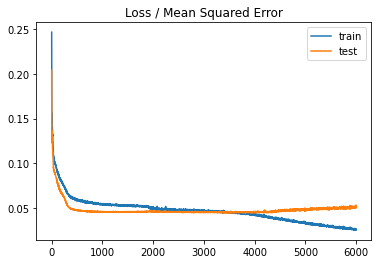

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


In [13]:
def train_lstm(X_train, y_train, X_test, y_test, lstm_units, dropout_prob, epochs, batch_size):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True,
                input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_prob))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    # Adding the output layer
    model.add(Dense(units=1))

    # Adam optimizer
    opt = Adam(learning_rate=0.0005, epsilon=1e-06, decay=1e-06)
    # # PiecewiseConstantDecay optimizer
    # boundaries = [200, 800, 2000, 4000]
    # values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
    # opt = keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries, values)

    checkpoint = ModelCheckpoint("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss", monitor='val_loss', verbose=2,
                                 save_best_only=True, mode='auto')

    # Compiling the RNN
    # model.compile(optimizer = opt, loss = 'mean_squared_error')
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[checkpoint])

    # evaluate the model
    train_mse = model.evaluate(X_train, y_train)
    test_mse = model.evaluate(X_test, y_test)
    print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
    # plot loss during training
    plt.title('Loss / Mean Squared Error')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

model = train_lstm(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lstm_units, dropout_prob, epochs, batch_size)
model.save('/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest')

### Test model

In [14]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    cm = confusion_matrix(y_true_direction, y_pred_direction, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    return accuracy_score(y_true_direction, y_pred_direction)

In [16]:
# X_test = X_train
lstm_model = keras.models.load_model("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss")

In [17]:
#@title Define some params for make decision { run: "auto" }
min_price_change = 0 #@param {type:"number"}


In [18]:
predicted_stock_price = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [19]:
y_test, predicted_stock_price

(array([[ 87.43000031],
        [264.69000244],
        [ 54.33000183],
        ...,
        [ 36.77000046],
        [ 21.45000076],
        [ 20.82500076]]), array([[ 86.59463 ],
        [251.80092 ],
        [ 54.010487],
        ...,
        [ 36.56123 ],
        [ 21.492582],
        [ 20.704025]], dtype=float32))

In [20]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[0.84]
 [12.89]
 [0.32]
 ...
 [0.21]
 [-0.04]
 [0.12]]
[32925.75]


rmse: 838.6247976212575 mape: 1.836549498190309
confusion_matrix: [[460   0 517]
 [  0   0   0]
 [458   0 561]]
acc: 0.5115230460921844


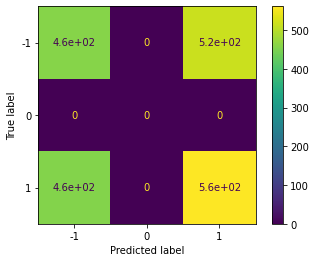

In [21]:
# Calculate RMSE and MAPE
from sklearn.metrics import mean_squared_error

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

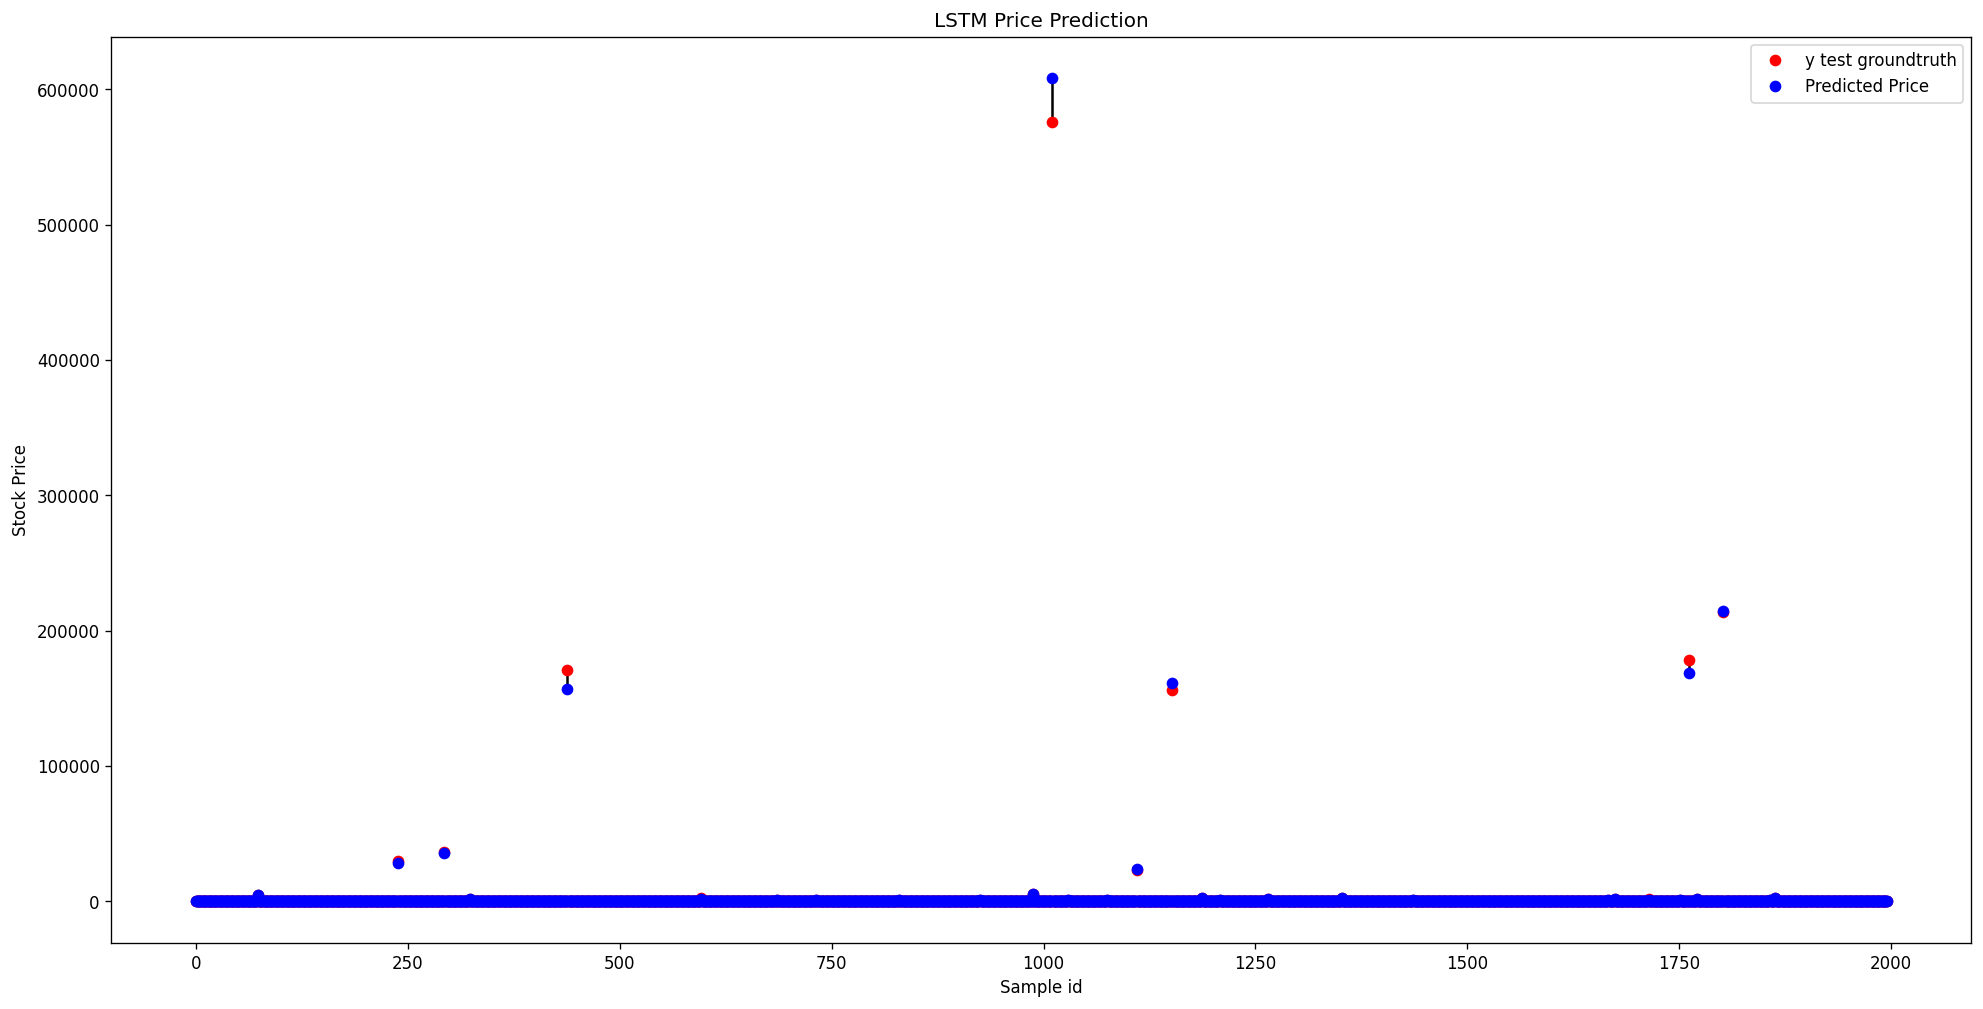

In [22]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('LSTM Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## XGBoost model

### Build model

In [23]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBRegressor

xgbmodel = XGBRegressor(seed=seed,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        colsample_bylevel=colsample_bylevel,
                        gamma=gamma)

### Train the model

In [24]:
xgbmodel.fit(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1])), np.reshape(y_train_scaled, (y_train_scaled.shape[0])))

[16:25:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

### Test model

In [25]:
predicted_stock_price = xgbmodel.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1])))
predicted_stock_price = np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], 1))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [26]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[0.74]
 [10.90]
 [0.30]
 ...
 [0.09]
 [-0.01]
 [0.13]]
[46714.31]


rmse: 1155.8596131786942 mape: 1.8486008594346803
confusion_matrix: [[441   0 536]
 [  0   0   0]
 [454   0 565]]
acc: 0.5040080160320641


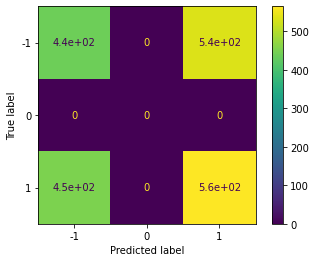

In [27]:
rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

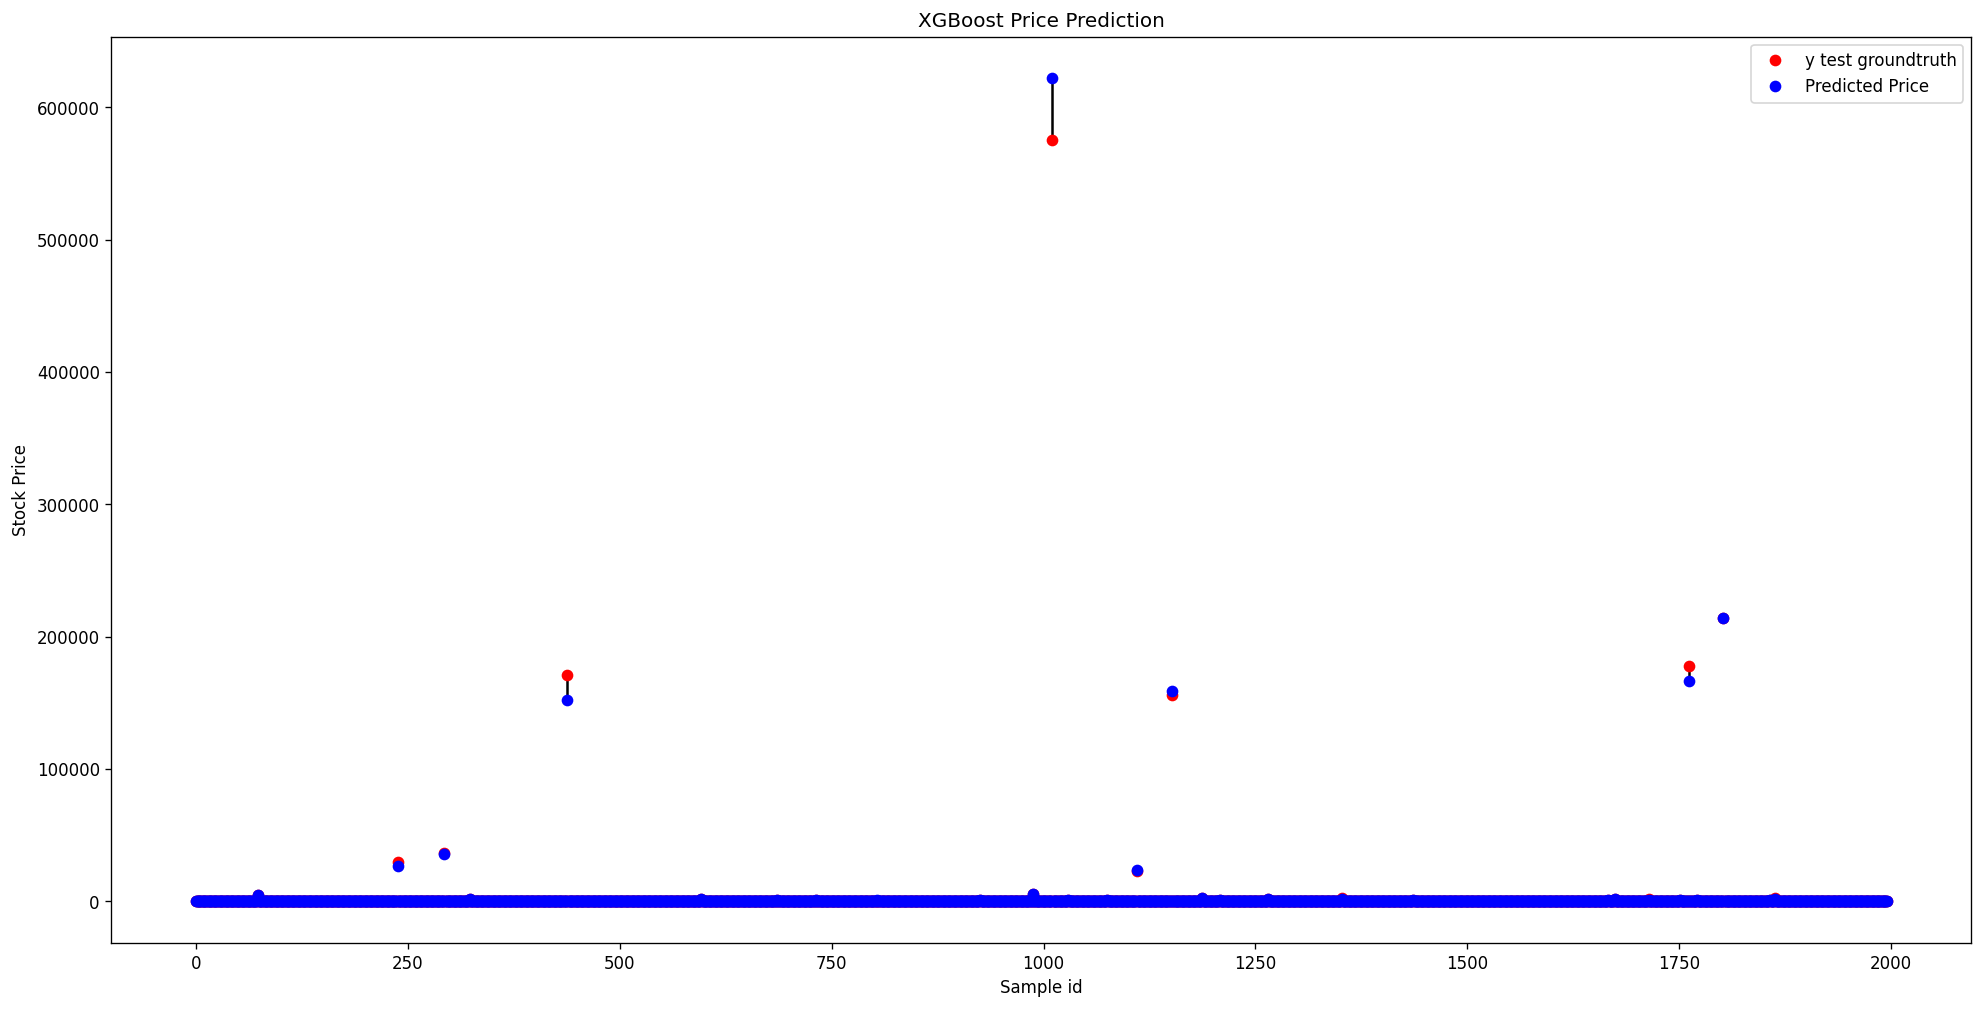

In [28]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('XGBoost Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()